In [1]:
############################################
BaseDir      = 'IntroDDSJpn/Appendix/'
OutputDir    = 'ARidge-Polynomial/'
FileBaseName = 'ARidge-Polynomial'

* Google Colabかどうかを判別し、このJupyter Notebookのあるディレクトリを特定します。

In [2]:
############################################
import sys
import os
############################################
def IsGoogleColab():
  if 'google.colab' in sys.modules:
    return True
  else:
    return False
############################################
if IsGoogleColab():
  #
  from google.colab import drive
  drive.mount('/content/drive')
  #
  IpynbDir = 'drive/My Drive/Colab Notebooks/' + BaseDir
else:
  #
  IpynbDir =  os.getcwd() + '/'
############################################
print( 'ipynb file path = %s' % IpynbDir )

ipynb file path = d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Appendix/


* 必要なパッケージを読み込み、ファイルの出力先のディレクトリを用意します。

In [3]:
############################################
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
print('matplotlib Ver.', mpl.__version__)
#
############################################
import numpy as np
import numpy.random as rd
print('numpy      Ver.', np.__version__)
#
############################################
import sklearn as skl
import sklearn.linear_model as lm
import sklearn.preprocessing as prep
print('sklearn    Ver.', skl.__version__)
#
############################################
FilePath = IpynbDir + OutputDir
print( 'FilePath = %s' % FilePath )
#
if( True != os.path.isdir(FilePath) ):
    print('  making %s' % FilePath )
    os.mkdir(FilePath)
else:
    print(' %s is exist.' % FilePath )

matplotlib Ver. 3.9.2
numpy      Ver. 1.26.4
sklearn    Ver. 1.5.2
FilePath = d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Appendix/ARidge-Polynomial/
  making d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Appendix/ARidge-Polynomial/


* 多項式回帰を線形モデル
$$
y_{m}
=
a_{0}
+
\sum_{n=1}^{N}
a_n
x_m^n
$$

* $\boldsymbol{\omega}=(a_1, \cdots, a_n, \cdots, a_N)$

* 計画行列 $\boldsymbol{X}$

$$
\boldsymbol{X}
=
\left(
  \begin{array}{ccccc}
  x_1 & \cdots & x_1^n & \cdots & x_1^N \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  x_m & \cdots & x_m^n & \cdots & x_m^N \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  x_M & \cdots & x_M^n & \cdots & x_M^N
  \end{array}
\right)
$$

* 線形写像
$$
\boldsymbol{y}=\boldsymbol{X}\boldsymbol{\omega}+a_{0},
$$
$$
\left(
  \begin{array}{c}
  y_1\\
  \vdots \\
  y_m \\
  \vdots \\
  y_M
  \end{array}
\right)
=
\left(
  \begin{array}{c}
  a_0\\
  \vdots \\
  a_0 \\
  \vdots \\
  a_0
  \end{array}
\right)
+
\left(
  \begin{array}{ccccc}
  x_1 & \cdots & x_1^n & \cdots & x_1^N \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  x_m & \cdots & x_m^n & \cdots & x_m^N \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  x_M & \cdots & x_M^n & \cdots & x_M^N
  \end{array}
\right)
\left(
  \begin{array}{c}
  a_1\\
  \vdots \\
  a_n \\
  \vdots \\
  a_N
  \end{array}
\right)
$$

真値を準備する
* $K=11$とする。
* $a_0=0.2,\,a_1=1.0,\,a_2=0.2,\,a_3=-0.3$ として、それ以外は0とする。
$$
y=0.2+1.0x+0.2x^2-0.3x^3
$$

In [4]:
############################################
# y=0.2+1.0X+0.2X^{2}-0.3X^{3}
#
a_0 = 0.25
#
w_K = 11 - 1
#
w_true = np.zeros((w_K,))
# a_1
w_true[0] = 1.0
# a_2
w_true[1] = 0.2
# a_3
w_true[2] = -0.3
#
print(w_true)

[ 1.   0.2 -0.3  0.   0.   0.   0.   0.   0.   0. ]


解析データの準備
* データ点数: $M=51$
* $x$値の範囲: $x=[-2.0, +2.0]$

In [5]:
############################################
M = 51 # 201
#
x = np.linspace(-2.0,+2.0, num=M, endpoint=True)
#
print(x)

[-2.   -1.92 -1.84 -1.76 -1.68 -1.6  -1.52 -1.44 -1.36 -1.28 -1.2  -1.12
 -1.04 -0.96 -0.88 -0.8  -0.72 -0.64 -0.56 -0.48 -0.4  -0.32 -0.24 -0.16
 -0.08  0.    0.08  0.16  0.24  0.32  0.4   0.48  0.56  0.64  0.72  0.8
  0.88  0.96  1.04  1.12  1.2   1.28  1.36  1.44  1.52  1.6   1.68  1.76
  1.84  1.92  2.  ]


計画行列$X$の準備
$$
\boldsymbol{X}
=
\left(
  \begin{array}{ccccc}
  x_1 & \cdots & x_1^n & \cdots & x_1^N \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  x_m & \cdots & x_m^n & \cdots & x_m^N \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  x_M & \cdots & x_M^n & \cdots & x_M^N
  \end{array}
\right)
$$

In [6]:
############################################
X = np.zeros((M, w_K))
#
for k in range(w_K):
    X[:,k] = x**(k+1)
#
print(X)

[[-2.00000000e+00  4.00000000e+00 -8.00000000e+00  1.60000000e+01
  -3.20000000e+01  6.40000000e+01 -1.28000000e+02  2.56000000e+02
  -5.12000000e+02  1.02400000e+03]
 [-1.92000000e+00  3.68640000e+00 -7.07788800e+00  1.35895450e+01
  -2.60919263e+01  5.00964985e+01 -9.61852772e+01  1.84675732e+02
  -3.54577406e+02  6.80788619e+02]
 [-1.84000000e+00  3.38560000e+00 -6.22950400e+00  1.14622874e+01
  -2.10906087e+01  3.88067201e+01 -7.14043650e+01  1.31384032e+02
  -2.41746618e+02  4.44813777e+02]
 [-1.76000000e+00  3.09760000e+00 -5.45177600e+00  9.59512576e+00
  -1.68874213e+01  2.97218616e+01 -5.23104763e+01  9.20664384e+01
  -1.62036931e+02  2.85184999e+02]
 [-1.68000000e+00  2.82240000e+00 -4.74163200e+00  7.96594176e+00
  -1.33827822e+01  2.24830740e+01 -3.77715644e+01  6.34562281e+01
  -1.06606463e+02  1.79098858e+02]
 [-1.60000000e+00  2.56000000e+00 -4.09600000e+00  6.55360000e+00
  -1.04857600e+01  1.67772160e+01 -2.68435456e+01  4.29496730e+01
  -6.87194767e+01  1.09951163e+02

真値データの準備。
$$\boldsymbol{y}=\boldsymbol{X}\boldsymbol{\omega}+a_0$$

In [7]:
############################################
y_true = X @ w_true + a_0
#
print(y_true)

[ 1.45       1.1906464  0.9559712  0.7450528  0.5569696  0.3908
  0.2456224  0.1205152  0.0145568 -0.0731744 -0.1436    -0.1976416
 -0.2362208 -0.2602592 -0.2706784 -0.2684    -0.2543456 -0.2294368
 -0.1945952 -0.1507424 -0.0988    -0.0396896  0.0256672  0.0963488
  0.1714336  0.25       0.3311264  0.4138912  0.4973728  0.5806496
  0.6628     0.7429024  0.8200352  0.8932768  0.9617056  1.0244
  1.0804384  1.1288992  1.1688608  1.1994016  1.2196     1.2285344
  1.2252832  1.2089248  1.1785376  1.1332     1.0719904  0.9939872
  0.8982688  0.7839136  0.65     ]


誤差を重畳させたデータの準備。
* $\boldsymbol{y}_1=\boldsymbol{y}_{\rm true}+{\cal N}(0,\sigma_{1});\;(\sigma_{1}=3.0\times10^{-1})$

In [8]:
############################################
rd.seed(89218)# デモデータなので、同じ結果になるように乱数のシードを設定
############################################
noise = rd.randn(M).reshape(M,)
# ノイズの平均値を0、標準偏差を1に規格化
noise = noise - np.mean( noise )
noise = noise / np.std( noise )
y_1 = y_true + 3.0E-1 * noise # 1.0E-1 * noise

グラフを描く関数

In [9]:
############################################
def Grf_data( x_data, y_sets, memo=None, title=None ):
  #
  plt.rcParams['font.size'] = 16
  #
  fig = plt.figure( figsize=(7,7) )
  fig.subplots_adjust(left=0.18, right=0.97, top=0.85, bottom=0.1)
  #
  ax1 = fig.add_subplot(1,1,1)
  #
  x_left, x_right = ax1.set_xlim( -2.2, 2.2 )
  ax1.set_xlabel( r'$x$' )
  #
  y_bot, y_top = ax1.set_ylim( -2.0, 2.0 )
  ax1.set_ylabel( r'$y$' )
  #
  for y_set in y_sets:
    # [y_data, plottype, label, 'color', size/linewidth, marker/linestyle]
    #   plottype = 0 -> plot
    #   plottype = 1 -> scatter
    if   y_set[1] == 0:
      #
      ax1.plot( x_data, y_set[0], label=y_set[2], color=y_set[3], linewidth=y_set[4], linestyle=y_set[5] )
      #
    elif y_set[1] == 1:
      #
      ax1.scatter( x_data, y_set[0], label=y_set[2], color=y_set[3], s=y_set[4], marker=y_set[5] )
      #
  #
  if title is not None:
    plt.title( title + r': $y_m=a_0 + \sum_{n=1}^{N}a_n x_m^n$' )
  else:
    plt.title( r'$y_m=a_0 + \sum_{n=1}^{N}a_n x_m^n$' )
  #
  plt.legend(loc='lower right')
  #
  if memo is not None:
    plt.text(x_left, y_bot, memo, fontsize=16,
             horizontalalignment='left',
             verticalalignment='bottom')

  #
  plt.show()
  #
  return fig

データのグラフ描画

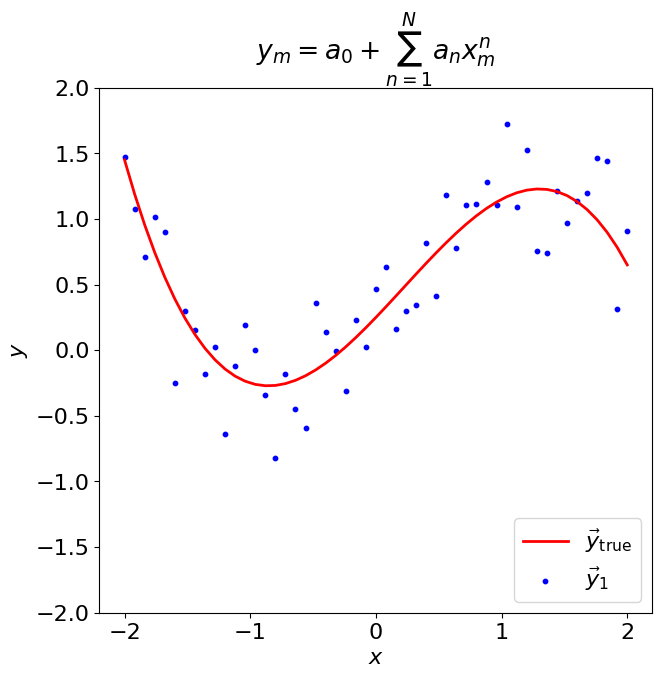

In [10]:
############################################
y_true_set = [ y_true, 0, r'$\vec{y}_{\rm true}$', 'red',  2, 'solid' ]
y_1_set    = [ y_1,    1, r'$\vec{y}_{1}$',       'blue', 10, 'o' ]
#
############################################
y_sets     = [ y_true_set, y_1_set ]
fig = Grf_data( x, y_sets )
#
fig.savefig( FilePath + FileBaseName + '-y1.pdf' )

計画行列$X$を標準化する
* 元行列:
$$
\boldsymbol{X}
=
\left(
  \begin{array}{ccccc}
  X_{11} & \cdots & X_{1n} & \cdots & X_{1N} \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  X_{m1} & \cdots & X_{mn} & \cdots & X_{mN} \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  X_{M1} & \cdots & X_{Mn} & \cdots & X_{MN}
  \end{array}
\right)
$$

* 標準化
```
scalerX = prep.StandardScaler()
scalerX.fit( X )
X_ss = scalerX.transform( X )
```
$$
\tilde{X_{mn}}=\frac{
  X_{mn}-\mu_n
}{
  s_n
}
$$

1. $\mu_n$:  scalerX.mean_[n]
$$
\boldsymbol{\mu}
=
\left(
  \begin{array}{c}
    \mu_{1} \\
    \vdots  \\
    \mu_{n} \\
    \vdots  \\
    \mu_{N}
  \end{array}
\right)
$$

2. $s_n$:    scalerX.scale_[n]

$$
\boldsymbol{s}
=
\left(
  \begin{array}{c}
    s_{1} \\
    \vdots  \\
    s_{n} \\
    \vdots  \\
    s_{N}
  \end{array}
\right)
,
\quad
\boldsymbol{s'}
=
\left(
  \begin{array}{c}
    \frac{1}{s_{1}} \\
    \vdots  \\
    \frac{1}{s_{n}} \\
    \vdots  \\
    \frac{1}{s_{N}}
  \end{array}
\right)
$$


* 標準化された行列:
$$
\tilde{\boldsymbol{X}}
=
\left(
  \begin{array}{ccccc}
  \tilde{X_{11}} & \cdots & \tilde{X_{1n}} & \cdots & \tilde{X_{1N}} \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  \tilde{X_{m1}} & \cdots & \tilde{X_{mn}} & \cdots & \tilde{X_{mN}} \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  \tilde{X_{M1}} & \cdots & \tilde{X_{Mn}} & \cdots & \tilde{X_{MN}}
  \end{array}
\right)
$$
1. $\tilde{X_{1n}},\cdots, \tilde{X_{mn}}, \cdots, \tilde{X_{Mn}}$の平均値が0
2. $\tilde{X_{1n}},\cdots, \tilde{X_{mn}}, \cdots, \tilde{X_{Mn}}$の標準偏差が1

に標準化される。

$$
\tilde{\boldsymbol{X}}
=
\left(
  \begin{array}{ccccc}
  \frac{X_{11}-\mu_1}{s_1} & \cdots &
  \frac{X_{1n}-\mu_n}{s_n} & \cdots &
  \frac{X_{1N}-\mu_N}{s_N}
  \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  \frac{X_{m1}-\mu_1}{s_1} & \cdots &
  \frac{X_{mn}-\mu_n}{s_n} & \cdots &
  \frac{X_{mN}-\mu_N}{s_N}
  \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  \frac{X_{M1}-\mu_1}{s_1} & \cdots &
  \frac{X_{Mn}-\mu_n}{s_n} & \cdots &
  \frac{X_{MN}-\mu_N}{s_N}
  \end{array}
\right)
$$


* 標準化していない$\boldsymbol{X}$と切片項$a_0$を用いると、

$$\boldsymbol{y}\approx\boldsymbol{X}\boldsymbol{\omega}+a_0$$

* $\tilde{\boldsymbol{X}}$を使って得られた解を$\hat{\tilde{\boldsymbol{\omega}}}$、切片項を$\hat{a}_0$とする。

$$\boldsymbol{y}\approx\tilde{\boldsymbol{X}}\hat{\tilde{\boldsymbol{\omega}}}+\hat{a}_0$$

$$
\left(
  \begin{array}{c}
    y_{1} - \hat{a}_0 \\
    \vdots            \\
    y_{m} - \hat{a}_0 \\
    \vdots            \\
    y_{M} - \hat{a}_0
  \end{array}
\right)
=
\left(
  \begin{array}{ccccc}
  \frac{X_{11}-\mu_1}{s_1} & \cdots &
  \frac{X_{1n}-\mu_n}{s_n} & \cdots &
  \frac{X_{1N}-\mu_N}{s_N}
  \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  \frac{X_{m1}-\mu_1}{s_1} & \cdots &
  \frac{X_{mn}-\mu_n}{s_n} & \cdots &
  \frac{X_{mN}-\mu_N}{s_N}
  \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  \frac{X_{M1}-\mu_1}{s_1} & \cdots &
  \frac{X_{Mn}-\mu_n}{s_n} & \cdots &
  \frac{X_{MN}-\mu_N}{s_N}
  \end{array}
\right)
\left(
  \begin{array}{c}
    \hat{\tilde{\omega}}_{1} \\
    \vdots                   \\
    \hat{\tilde{\omega}}_{n} \\
    \vdots                   \\
    \hat{\tilde{\omega}}_{N}
  \end{array}
\right)
$$

$$
=
\left(
  \begin{array}{ccccc}
  X_{11}-\mu_1 & \cdots &
  X_{1n}-\mu_n & \cdots &
  X_{1N}-\mu_N
  \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  X_{m1}-\mu_1 & \cdots &
  X_{mn}-\mu_n & \cdots &
  X_{mN}-\mu_N
  \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  X_{M1}-\mu_1 & \cdots &
  X_{Mn}-\mu_n & \cdots &
  X_{MN}-\mu_N
  \end{array}
\right)
\left(
  \begin{array}{c}
    \frac{\hat{\tilde{\omega}}_{1}}{s_{1}} \\
    \vdots                   \\
    \frac{\hat{\tilde{\omega}}_{n}}{s_{n}} \\
    \vdots                   \\
    \frac{\hat{\tilde{\omega}}_{N}}{s_{N}}
  \end{array}
\right)
$$

$$
=
\left(
  \begin{array}{ccccc}
  X_{11} & \cdots &
  X_{1n} & \cdots &
  X_{1N}
  \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  X_{m1} & \cdots &
  X_{mn} & \cdots &
  X_{mN}
  \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  X_{M1} & \cdots &
  X_{Mn} & \cdots &
  X_{MN}
  \end{array}
\right)
\left(
  \begin{array}{c}
    \frac{\hat{\tilde{\omega}}_{1}}{s_{1}} \\
    \vdots                   \\
    \frac{\hat{\tilde{\omega}}_{n}}{s_{n}} \\
    \vdots                   \\
    \frac{\hat{\tilde{\omega}}_{N}}{s_{N}}
  \end{array}
\right)
-
\left(
  \begin{array}{ccccc}
  \mu_1 & \cdots &
  \mu_n & \cdots &
  \mu_N
  \end{array}
\right)
\left(
  \begin{array}{c}
    \frac{\hat{\tilde{\omega}}_{1}}{s_{1}} \\
    \vdots                   \\
    \frac{\hat{\tilde{\omega}}_{n}}{s_{n}} \\
    \vdots                   \\
    \frac{\hat{\tilde{\omega}}_{N}}{s_{N}}
  \end{array}
\right)
$$

よって、

$$
\boldsymbol{y}-\hat{a}_0
\approx
\tilde{\boldsymbol{X}}\hat{\tilde{\boldsymbol{\omega}}}
=
\boldsymbol{X}\,
\left(
  \boldsymbol{s'}\,\circ\,\hat{\tilde{\boldsymbol{\omega}}}
\right)
-
\boldsymbol{\mu}\,\cdot\,
\left(
  \boldsymbol{s'}\,\circ\,\hat{\tilde{\boldsymbol{\omega}}}
\right)
$$

$$
\therefore\,\,\,
\boldsymbol{y}
\approx
\tilde{\boldsymbol{X}}\hat{\tilde{\boldsymbol{\omega}}}
+\hat{a}_0
=
\boldsymbol{X}\,
\left(
  \boldsymbol{s'}\,\circ\,\hat{\tilde{\boldsymbol{\omega}}}
\right)
-
\boldsymbol{\mu}\,\cdot\,
\left(
  \boldsymbol{s'}\,\circ\,\hat{\tilde{\boldsymbol{\omega}}}
\right)
+
\hat{a}_0
$$

一方

$$\boldsymbol{y}=\boldsymbol{X}\boldsymbol{\omega}+a_0$$

なので、

$$\boldsymbol{\omega}
  \,
  \leftarrow
  \,
  \boldsymbol{s'}\,\circ\,\hat{\tilde{\boldsymbol{\omega}}}
$$

$$a_{0}
  \,
  \leftarrow
  \,
  \hat{a}_0
  -
  \boldsymbol{\mu}\,\cdot\,
  \left(
    \boldsymbol{s'}\,\circ\,\hat{\tilde{\boldsymbol{\omega}}}
  \right)
$$

ここで、$\circ$はアダマール積(Hadamard product)である。

In [11]:
############################################
scalerX = prep.StandardScaler()
scalerX.fit( X )
#
X_ss = scalerX.transform( X )
#
mu_vec     = scalerX.mean_
sdash_vec  = 1 / scalerX.scale_

---
L2正則化 / Ridge 回帰
* sklearn.linear_model.Ridge
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

* 引数:
  * alpha: $\alpha$
  * fit_intercept: 切片を推定するか否か (default=True)
  * max_iter: イタレーションの最大回数 (default=1000)
  * positive: coefを正値に制約 (default=False)
* 返値:
  * coef_: $\hat{\boldsymbol{\omega}}$ 回帰係数
  * intercept_: 切片項

In [12]:
############################################
y_target = y_1
#
a = 1.0E-3
# a = 1.000E+05 : L0 = 10 : RMSD_reg_target_ = 6.376E-01 : RMSD_reg_true_ = 5.443E-01 : RMSD_w_true_ = 3.238E-01
# a = 1.000E-03 : L0 = 10 : RMSD_reg_target_ = 2.902E-01 : RMSD_reg_true_ = 6.856E-02 : RMSD_w_true_ = 1.782E-01
#
############################################
print( 'a = %.3E : ' % a, end='' )
#
ridge = lm.Ridge( alpha = a, fit_intercept=True, max_iter=1000000 )
ridge.fit( X_ss, y_target )
#
w_  = ridge.coef_
a0_ = ridge.intercept_
#
# 再現データ
y_reg_ = X_ss @ w_ + a0_
#
# 非ゼロ成分数
L0_ = np.count_nonzero( w_ )
print( 'L0 = %2d : ' % L0_, end='')
#
# RMSD
RMSD_reg_target_ = np.std( (y_target - y_reg_) )
RMSD_reg_true_   = np.std( (y_true   - y_reg_) )
print( 'RMSD_reg_target_ = %.3E : ' % RMSD_reg_target_, end='' )
print( 'RMSD_reg_true_ = %.3E : ' % RMSD_reg_true_, end='' )
#
w_org_ = sdash_vec * w_
#
RMSD_w_true_     = np.std( (w_true   - w_org_) )
print( 'RMSD_w_true_ = %.3E' % RMSD_w_true_     )

a = 1.000E-03 : L0 = 10 : RMSD_reg_target_ = 2.902E-01 : RMSD_reg_true_ = 6.856E-02 : RMSD_w_true_ = 1.782E-01


$\alpha$のテーブルを準備
* $\alpha=1\times10^{-3}\sim1\times10^{4}$で等比数列で用意
* 個数は50個

In [13]:
############################################
n_alphas = 50 # 200
#
alpha_max = 1.0E+4
alpha_min = 1.0E-3
#
alphas = np.logspace( np.log10(alpha_max), np.log10(alpha_min), n_alphas)
#
print(alphas)

[1.00000000e+04 7.19685673e+03 5.17947468e+03 3.72759372e+03
 2.68269580e+03 1.93069773e+03 1.38949549e+03 1.00000000e+03
 7.19685673e+02 5.17947468e+02 3.72759372e+02 2.68269580e+02
 1.93069773e+02 1.38949549e+02 1.00000000e+02 7.19685673e+01
 5.17947468e+01 3.72759372e+01 2.68269580e+01 1.93069773e+01
 1.38949549e+01 1.00000000e+01 7.19685673e+00 5.17947468e+00
 3.72759372e+00 2.68269580e+00 1.93069773e+00 1.38949549e+00
 1.00000000e+00 7.19685673e-01 5.17947468e-01 3.72759372e-01
 2.68269580e-01 1.93069773e-01 1.38949549e-01 1.00000000e-01
 7.19685673e-02 5.17947468e-02 3.72759372e-02 2.68269580e-02
 1.93069773e-02 1.38949549e-02 1.00000000e-02 7.19685673e-03
 5.17947468e-03 3.72759372e-03 2.68269580e-03 1.93069773e-03
 1.38949549e-03 1.00000000e-03]


$\alpha$テーブルに従って、Ridge回帰を繰り返す
$$
\hat{\tilde{\boldsymbol{\omega}}}
=
{\rm arg min}_{\tilde{\boldsymbol{\omega}}}
\left(
  \left\|
    \boldsymbol{y}
    -
    \tilde{\boldsymbol{X}}
    \tilde{\boldsymbol{\omega}}
  \right\|_2^2
  +
  \alpha
  \left\|
    \tilde{\boldsymbol{\omega}}
  \right\|_2^2
\right)
$$

* $\hat{\tilde{\boldsymbol{\omega}}}$を使った再現データ
$$
\hat{\boldsymbol{y}}
=
\tilde{\boldsymbol{X}}\hat{\tilde{\boldsymbol{\omega}}}
+
\hat{\tilde{a}}_{0}
$$

* 以下の残差を求める

  * $\textrm{RMSD}(\boldsymbol{y} -\hat{\boldsymbol{y}})$ : 解析対象データ(ノイズ重畳)$\boldsymbol{y}$に対する、$\hat{\boldsymbol{y}}$の残差:

  * $\textrm{RMSD}(\boldsymbol{y}_{\rm true} -\hat{\boldsymbol{y}})$ : 真値データ$\boldsymbol{y}_{\rm true}$に対する、$\hat{\boldsymbol{y}}$の残差。但し計測データでは、真値データは不明なので、この残差はわからない。

* 標準化して得られた $\hat{\tilde{\boldsymbol{\omega}}}$, $\hat{\tilde{a}_{0}}$ を $\hat{\boldsymbol{\omega}}$, $\hat{a_{0}}$に戻す

    $$\hat{\boldsymbol{\omega}}
    \,
    \leftarrow
    \,
    \boldsymbol{s'}\,\circ\,\hat{\tilde{\boldsymbol{\omega}}}
    $$

    $$\hat{a}_{0}
    \,
    \leftarrow
    \,
    \hat{a}_0
    -
    \boldsymbol{\mu}\,\cdot\,
    \left(
      \boldsymbol{s'}\,\circ\,\hat{\tilde{\boldsymbol{\omega}}}
    \right)
    $$

* $\textrm{RMSD}(\boldsymbol{\omega}_{\rm true} -\hat{\boldsymbol{\omega}})$ : 真値の$\boldsymbol{\omega}_{\rm true}$に対する$\hat{\boldsymbol{\omega}}$ の残差。但し計測データでは、真値データは不明なので、この残差はわからない。

In [14]:
############################################
y_target = y_1
############################################
hat_y_reg = []
hat_L0    = []
hat_RMSD_reg_target = []
hat_RMSD_reg_true   = []
hat_RMSD_w_true     = []
hat_omega = []
hat_a0    = []
#
############################################
for a in alphas:
  ##########################################
  print( 'a = %.3E : ' % a, end='' )
  #
  ridge = lm.Ridge( alpha = a, fit_intercept=True, max_iter=1000000 )
  ridge.fit( X_ss, y_target )
  #
  w_  = ridge.coef_
  a0_ = ridge.intercept_
  #
  # 再現データ
  y_reg_ = X_ss @ w_ + a0_
  hat_y_reg.append( y_reg_ )
  #
  # 非ゼロ成分数
  L0_ = np.count_nonzero( w_ )
  print( 'L0 = %2d : ' % L0_, end='')
  hat_L0.append( L0_ )
  #
  # RMSD
  RMSD_reg_target_ = np.std( (y_target - y_reg_) )
  RMSD_reg_true_   = np.std( (y_true   - y_reg_) )
  print( 'RMSD_reg_target_ = %.3E : ' % RMSD_reg_target_, end='' )
  print( 'RMSD_reg_true_ = %.3E : ' % RMSD_reg_true_, end='' )
  hat_RMSD_reg_target.append( RMSD_reg_target_ )
  hat_RMSD_reg_true.append( RMSD_reg_true_ )
  #
  w_org_  = sdash_vec * w_
  a0_org_ = a0_ - mu_vec @ w_org_
  hat_omega.append( w_org_ )
  hat_a0.append( a0_org_   )
  #
  RMSD_w_true_     = np.std( (w_true   - w_org_) )
  print( 'RMSD_w_true_ = %.3E' % RMSD_w_true_    )
  hat_RMSD_w_true.append( RMSD_w_true_ )
  #

a = 1.000E+04 : L0 = 10 : RMSD_reg_target_ = 6.346E-01 : RMSD_reg_true_ = 5.412E-01 : RMSD_w_true_ = 3.235E-01
a = 7.197E+03 : L0 = 10 : RMSD_reg_target_ = 6.334E-01 : RMSD_reg_true_ = 5.399E-01 : RMSD_w_true_ = 3.233E-01
a = 5.179E+03 : L0 = 10 : RMSD_reg_target_ = 6.317E-01 : RMSD_reg_true_ = 5.381E-01 : RMSD_w_true_ = 3.231E-01
a = 3.728E+03 : L0 = 10 : RMSD_reg_target_ = 6.295E-01 : RMSD_reg_true_ = 5.357E-01 : RMSD_w_true_ = 3.228E-01
a = 2.683E+03 : L0 = 10 : RMSD_reg_target_ = 6.265E-01 : RMSD_reg_true_ = 5.325E-01 : RMSD_w_true_ = 3.224E-01
a = 1.931E+03 : L0 = 10 : RMSD_reg_target_ = 6.226E-01 : RMSD_reg_true_ = 5.283E-01 : RMSD_w_true_ = 3.219E-01
a = 1.389E+03 : L0 = 10 : RMSD_reg_target_ = 6.175E-01 : RMSD_reg_true_ = 5.229E-01 : RMSD_w_true_ = 3.212E-01
a = 1.000E+03 : L0 = 10 : RMSD_reg_target_ = 6.112E-01 : RMSD_reg_true_ = 5.162E-01 : RMSD_w_true_ = 3.202E-01
a = 7.197E+02 : L0 = 10 : RMSD_reg_target_ = 6.035E-01 : RMSD_reg_true_ = 5.079E-01 : RMSD_w_true_ = 3.189E-01
a

回帰係数 $\hat{\boldsymbol{\omega}}$ と、L0、RMSDを描画するグラフ関数

In [15]:
############################################
def SubGrf_omega_RMSD_L0( axis, alphas_, omegas_, a0_, L0s_, RMSD_sets_, idx_=None, title=None ):
  #
  #############
  # omega
  omegas_max = np.amax( np.abs( omegas_ ) )
  #
  axis.set_xscale( 'log' )
  axis.set_xlabel( r'$\alpha$' )
  #
  axis.set_ylabel( r'$\hat{\omega}$' )
  axis.set_ylim( -1.4 * omegas_max, 1.4 * omegas_max )
  #
  axis.plot( alphas_, omegas_ , zorder=0.2)
  axis.plot( alphas_, a0_, linestyle='dashed', color='gray', zorder=0.3 )
  #
  # a_0
  axis.axhline( y = a_0, linestyle='dotted', color='gray', zorder=0.1 )
  #
  # w_true
  for w_val in w_true:
    if w_val != 0.0:
      axis.axhline( y = w_val, linestyle='dotted', color='black', zorder=0.1 )
  #
  if idx_ is not None:
    idx_a_  = alphas_[ idx_ ]
    idx_L0_ = L0s_[ idx_ ]
    #
    axis.axvline( idx_a_, color='gray', linestyle='dashed',zorder=1.0 )
    #
    (axis_bot, axis_top) = axis.set_ylim()
    #
    idx_text = r'$\alpha=$%.2E' % idx_a_  +  r'$, L_{0}=%3d$' % idx_L0_
    axis.text( idx_a_, axis_bot + 0.05*(axis_top-axis_bot),
               idx_text, fontsize=12, rotation=90,
               horizontalalignment='center', verticalalignment='bottom',
               color='white', backgroundcolor='gray', zorder=2.0)
  #
  #############
  # RMSD
  axRMSD = axis.twinx()
  #
  RMSD_max_ = 0
  for RMSD_set_ in RMSD_sets_:
    #
    label_ = RMSD_set_[0]
    RMSD_  = RMSD_set_[1]
    #
    if np.amax( RMSD_ ) > RMSD_max_:
      RMSD_max_ = np.amax( RMSD_ )
    #
    axRMSD.scatter( alphas_, RMSD_, label=label_, zorder=0.5 )
  #
  axRMSD.set_ylim( 0, 1.5 * RMSD_max_ )
  axRMSD.set_ylabel( 'RMSD' )
  #
  axRMSDline, axRMSDlabel = axRMSD.get_legend_handles_labels()
  #
  #############
  # L0
  axL0 = axis.twinx()
  axL0.spines["right"].set_position(("axes", 1.18))
  axL0.spines['right'].set_color('red')
  axL0.tick_params(axis = 'y', colors ='red')
  #
  axL0.set_ylabel( r'$L_{0}$', color='red' )
  axL0.set_ylim( -0.2, 1.4 * np.amax( L0s_ ) )
  #
  axL0.scatter( alphas_, L0s_, label=r'$L_{0}$', color='red', zorder=0.6)
  #
  axL0line, axL0label = axL0.get_legend_handles_labels()
  #
  #
  # plt.legend(axRMSDline, axRMSDlabel, bbox_to_anchor=(1.35, 1.0), loc='upper left')
  plt.legend(axRMSDline + axL0line, axRMSDlabel + axL0label,
             loc='upper right', fontsize=12)
  #
  if title is not None:
    plt.title( title )
  else:
    plt.title(r'Ridge: $\hat{\omega}$, RMSD, $L_{0}$')
  #
  return
############################################
def Grf_omega_RMSD_L0( alphas_, omegas_, a0_, L0s_, RMSD_sets_, idx_=None, title=None  ):
  #
  plt.rcParams["font.size"] = 16
  #
  fig = plt.figure( figsize=(6.5, 5) )
  fig.subplots_adjust(left=0.15, right=0.77, top=0.93, bottom=0.13)
  #
  ax1 = fig.add_subplot(1,1,1)
  #
  SubGrf_omega_RMSD_L0( ax1, alphas_, omegas_, a0_, L0s_, RMSD_sets_, idx_=idx_ )
  #
  plt.show()
  #
  return fig

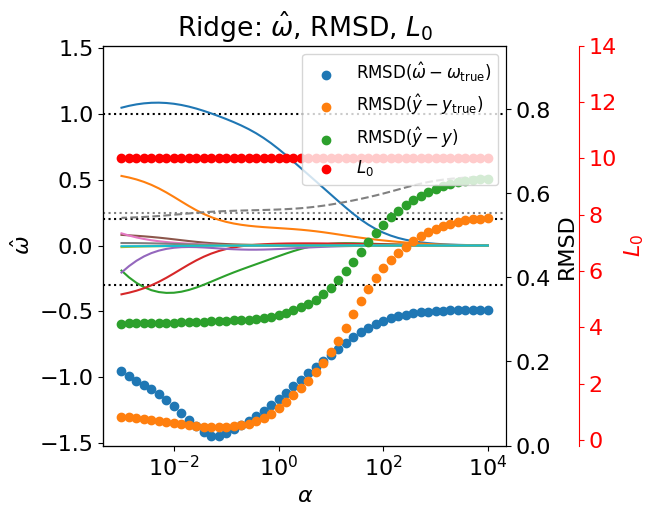

In [16]:
# hat_y_reg = []
# hat_L0    = []
# hat_RMSD_reg_target = []
# hat_RMSD_reg_true   = []
# hat_RMSD_w_true     = []
# hat_omega = []
# hat_a0    = []
############################################
RMSD_sets = [ [ r'RMSD($\hat{\omega}-\omega_{\rm true}$)', hat_RMSD_w_true    ],
              [ r'RMSD($\hat{y}-y_{\rm true}$)',           hat_RMSD_reg_true  ],
              [ r'RMSD($\hat{y}-y$)',                      hat_RMSD_reg_target] ]
############################################
# fig = Grf_omega_RMSD_L0( alphas, hat_omega, hat_a0, hat_L0, RMSD_sets, idx_=10 )
fig = Grf_omega_RMSD_L0( alphas, hat_omega, hat_a0, hat_L0, RMSD_sets )
fig.savefig( FilePath + FileBaseName + '-summary-01.pdf' )

yデータを描くグラフ

In [17]:
############################################
def SubGrf_ydata( axis, x_data, y_sets, title=None ):
  #
  x_left, x_right = axis.set_xlim( -2.2, 2.2 )
  axis.set_xlabel( r'$x$' )
  #
  y_bot, y_top = axis.set_ylim( -1.5, 2.0 )
  axis.set_ylabel( r'$y$' )
  #
  for y_set in y_sets:
    # [y_data, plottype, label, 'color', size/linewidth, marker/linestyle]
    #   plottype = 0 -> plot
    #   plottype = 1 -> scatter
    if   y_set[1] == 0:
      #
      axis.plot( x_data, y_set[0], label=y_set[2], color=y_set[3], linewidth=y_set[4], linestyle=y_set[5] )
      #
    elif y_set[1] == 1:
      #
      axis.scatter( x_data, y_set[0], label=y_set[2], color=y_set[3], s=y_set[4], marker=y_set[5] )
      #
  #
  plt.legend(loc='lower right', fontsize=12)
  #
  if title is not None:
    plt.title( title )
  #
  return
############################################
def Grf_ydata( x_data, y_sets, title=None ):
  #
  plt.rcParams['font.size'] = 16
  #
  fig = plt.figure( figsize=(5,5) )
  fig.subplots_adjust(left=0.18, right=0.97, top=0.95, bottom=0.13)
  #
  ax1 = fig.add_subplot(1,1,1)
  #
  SubGrf_ydata( ax1, x_data, y_sets, title )
  #
  plt.show()
  #
  return fig

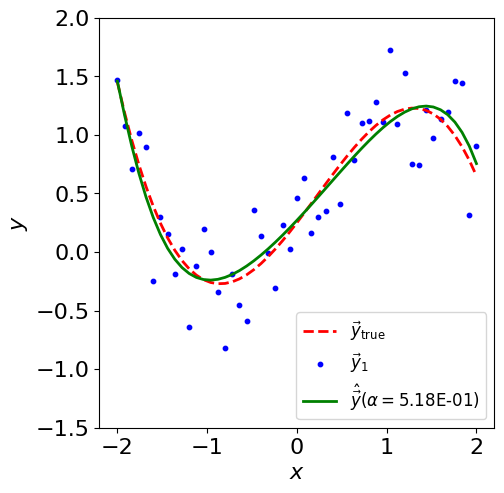

In [18]:
############################################
y_true_set = [ y_true, 0, r'$\vec{y}_{\rm true}$', 'red',  2, 'dashed' ]
y_1_set    = [ y_1,    1, r'$\vec{y}_{1}$',       'blue', 10, 'o' ]
#
############################################
alpha_idx = 30
#
#
############################################
a_ = alphas[ alpha_idx ]
y_label_ = r'$\hat{\vec{y}}(\alpha=$%.2E$)$' % a_
y_reg_set = [ hat_y_reg[alpha_idx], 0, y_label_, 'green', 2, 'solid' ]
#
###########################################
y_sets     = [ y_true_set, y_1_set, y_reg_set ]
fig = Grf_ydata( x, y_sets )
#
fname_ = FilePath + FileBaseName + '-idx%02d-yreg.pdf' % alpha_idx
fig.savefig( fname_ )

$\omega$データを描くグラフのための準備

In [19]:
###########################################
# omegaの横軸: 次数
w_x_all    = np.linspace( 0, 10, num=11)
# 切片項を先頭に追加
w_true_all = np.concatenate( [[a_0], w_true] )
#
# 1: scatter
# 0: vlines
w_true_set = [ w_true_all, 1, r'$\vec{\omega}_{\rm true}$', 'red',  20, 'o' ]
###########################################

In [20]:
############################################
alpha_idx = 30
#
w_idx_  = hat_omega[ alpha_idx ]
a0_idx_ = hat_a0[ alpha_idx ]
#
w_all_idx_ = np.concatenate( [[a0_idx_], w_idx_] )
#
w_all_idx_set = [ w_all_idx_, 0, r'$\hat{\vec{\omega}}$', 'green',  2, 'solid' ]

$\omega$データを描くグラフ

In [21]:
###########################################
def SubGrf_omega( axis, omega_x_, omega_sets_, title=None ):
  #
  axis.set_xlabel( 'Order' )
  #
  axis.set_ylabel( r'$\vec{\omega}$' )
  #
  max_intensity = 0
  for omega_set_ in omega_sets_:
    #
    omega_w_     = omega_set_[0]
    omega_w_int_ = np.abs( omega_w_ )
    omega_L0_    = np.count_nonzero( omega_w_ )
    omega_mode_  = omega_set_[1]
    omega_label_ = omega_set_[2] + ' (L0=%d)' % omega_L0_
    omega_color_ = omega_set_[3]
    omega_size_  = omega_set_[4]
    omega_type_  = omega_set_[5]
    #
    if np.amax( omega_w_int_ ) > max_intensity:
      max_intensity = np.amax( omega_w_int_ )
    #
    if omega_mode_ == 0:
      # 0: vlines
      axis.vlines( omega_x_, 0, omega_w_, label=omega_label_, colors=omega_color_, linewidth=omega_size_, linestyles=omega_type_ )
    elif omega_mode_ == 1:
      # 1: scatter
      axis.scatter( omega_x_, omega_w_, label=omega_label_, color=omega_color_, s=omega_size_, marker=omega_type_ )
    #
    axis.set_ylim( -1.2 * max_intensity, 1.2 * max_intensity )
    #
  #
  # zero
  axis.axhline( 0.0, color='black', linewidth=0.5, linestyle='dotted' )
  #
  plt.legend(loc='lower right', fontsize=12)
  #
  if title is not None:
    plt.title( title )
  #
  return omega_L0_
###########################################
def Grf_omega( omega_x_, omega_sets_, title=None ):
  #
  plt.rcParams['font.size'] = 16
  #
  fig = plt.figure( figsize=(5,5) )
  fig.subplots_adjust(left=0.18, right=0.97, top=0.95, bottom=0.13)
  #
  ax1 = fig.add_subplot(1,1,1)
  #
  SubGrf_omega( ax1, omega_x_, omega_sets_, title )
  #
  plt.show()
  #
  return fig

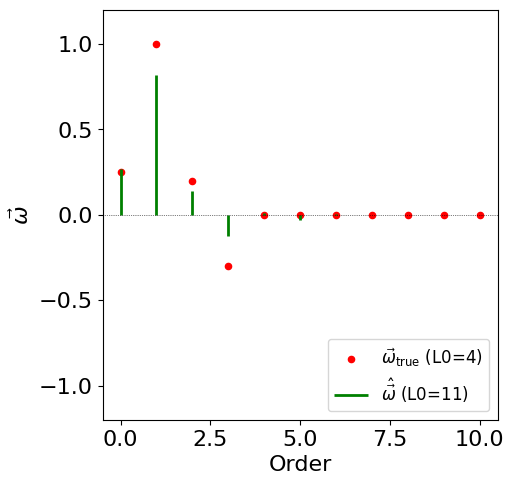

In [22]:
###########################################
# w_x_all
w_sets = [ w_true_set, w_all_idx_set ]
#
fig = Grf_omega( w_x_all, w_sets )
#
fname_ = FilePath + FileBaseName + '-idx%02d-omega.pdf' % alpha_idx
# fig.savefig( fname_ )

各$\alpha$でのまとめ図を描く

In [23]:
############################################
RMSD_sets = [ [ r'RMSD($\hat{\omega}-\omega_{\rm true}$)', hat_RMSD_w_true    ],
              [ r'RMSD($\hat{y}-y_{\rm true}$)',           hat_RMSD_reg_true  ],
              [ r'RMSD($\hat{y}-y$)',                      hat_RMSD_reg_target] ]
############################################
y_true_set = [ y_true, 0, r'$\vec{y}_{\rm true}$', 'red',  2, 'dashed' ]
y_1_set    = [ y_1,    1, r'$\vec{y}_{1}$',       'blue', 10, 'o' ]
###########################################
# omegaの横軸: 次数
w_x_all    = np.linspace( 0, 10, num=11)
# 切片項を先頭に追加
w_true_all = np.concatenate( [[a_0], w_true] )
#
# 1: scatter
# 0: vlines
###########################################
w_true_set = [ w_true_all, 1, r'$\vec{\omega}_{\rm true}$', 'red',  20, 'o' ]

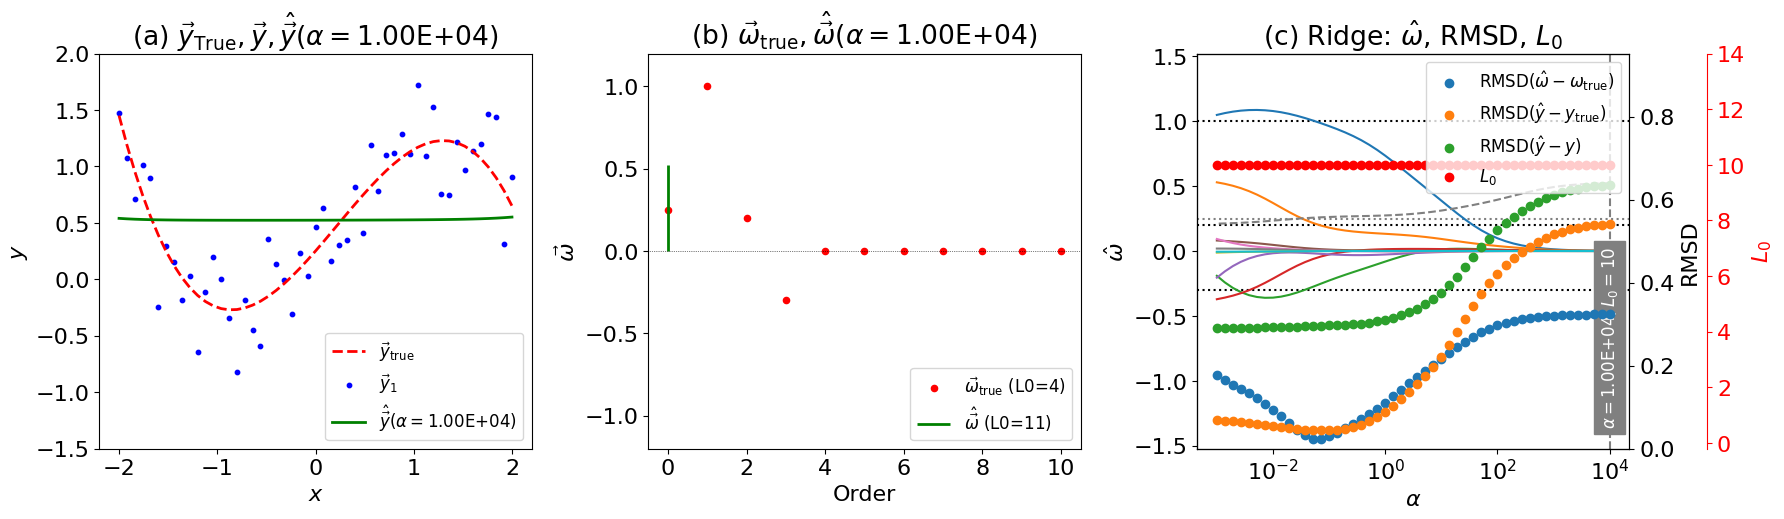

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Appendix/ARidge-Polynomial/ARidge-Polynomial-idx00-summary.pdf


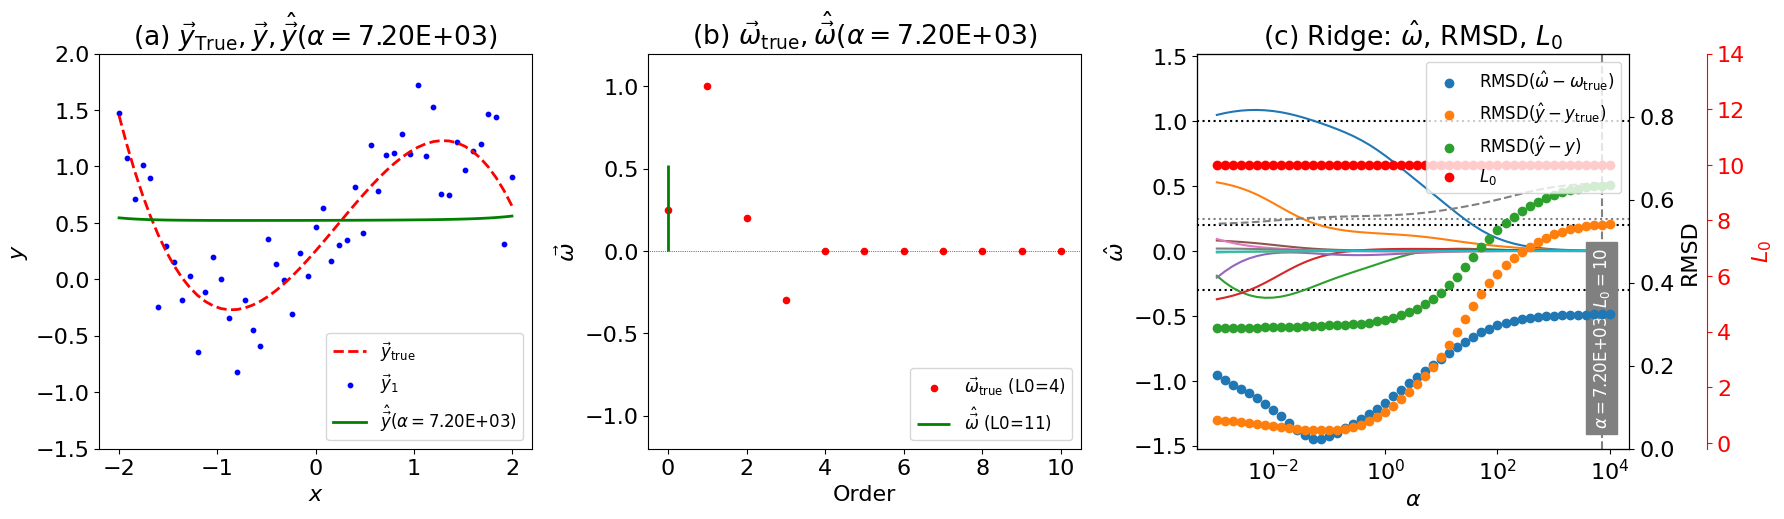

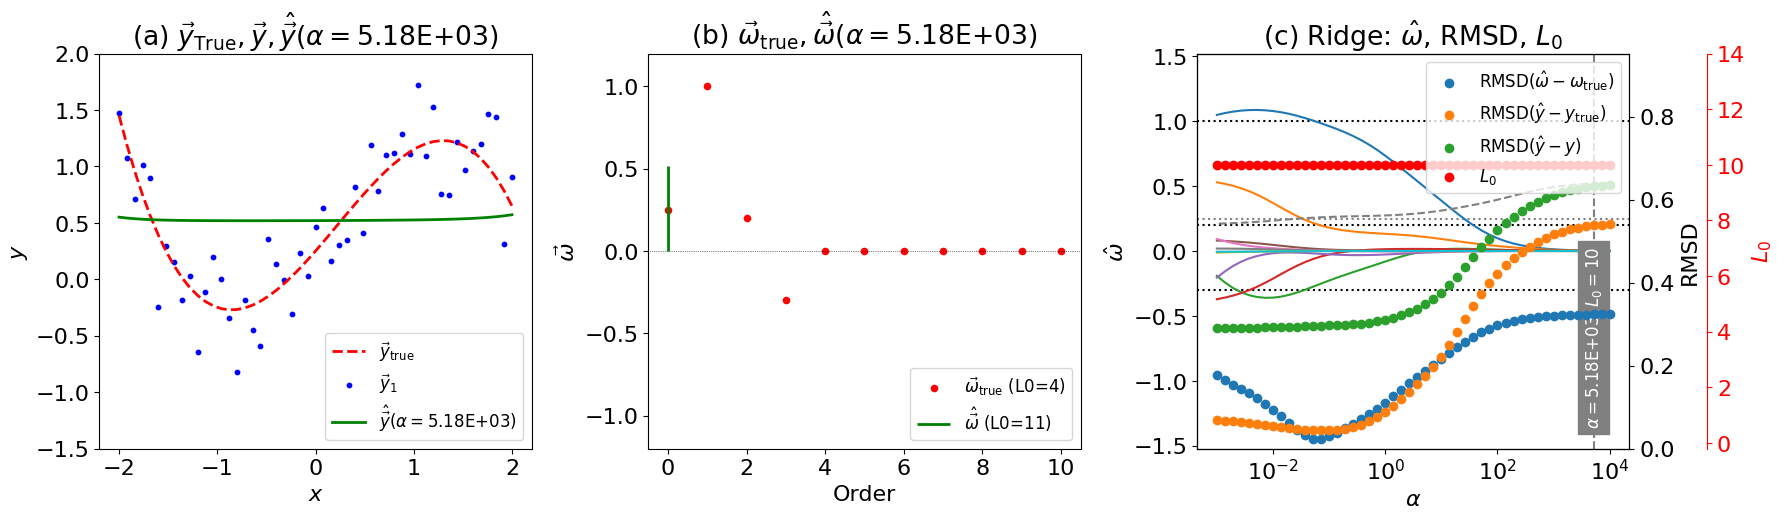

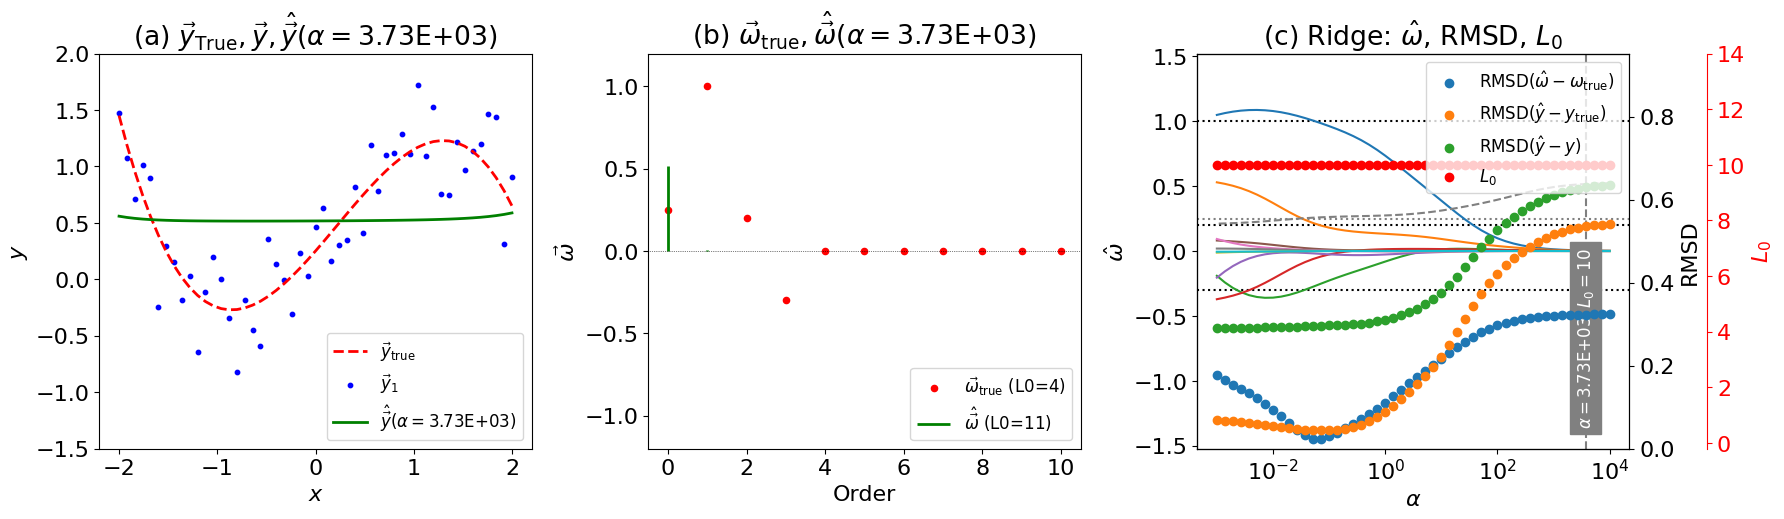

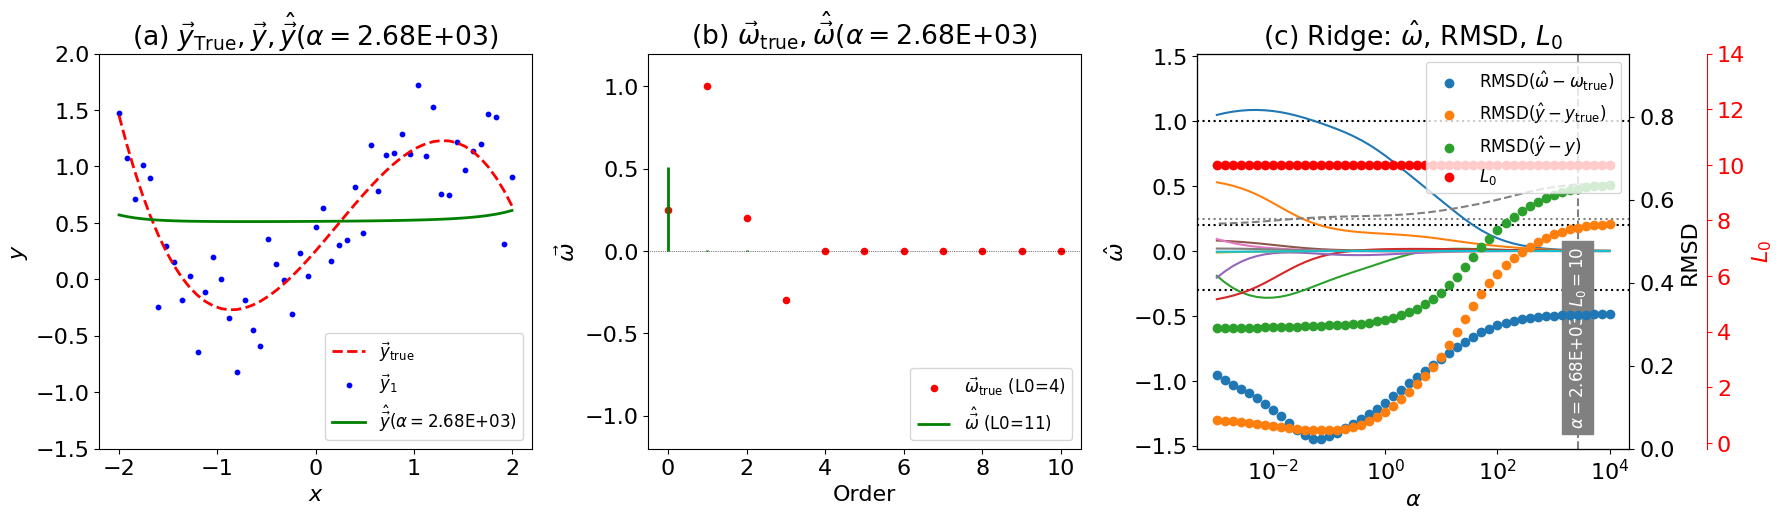

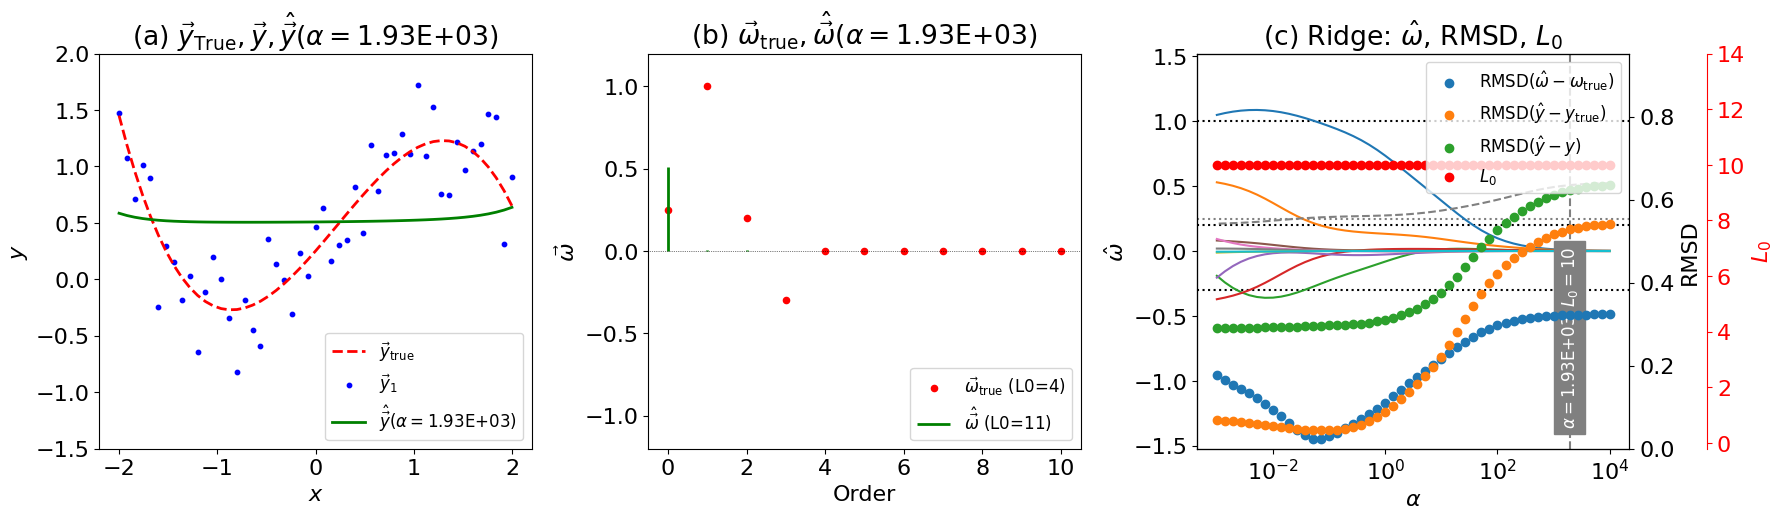

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Appendix/ARidge-Polynomial/ARidge-Polynomial-idx05-summary.pdf


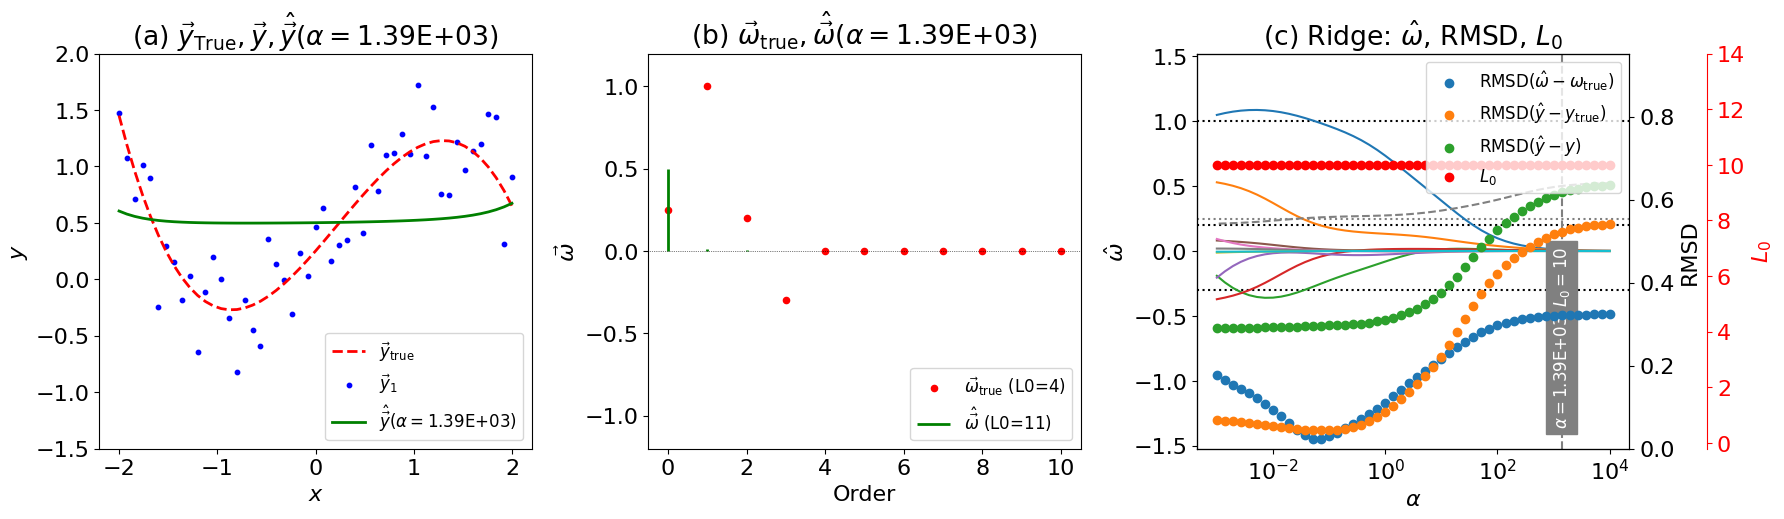

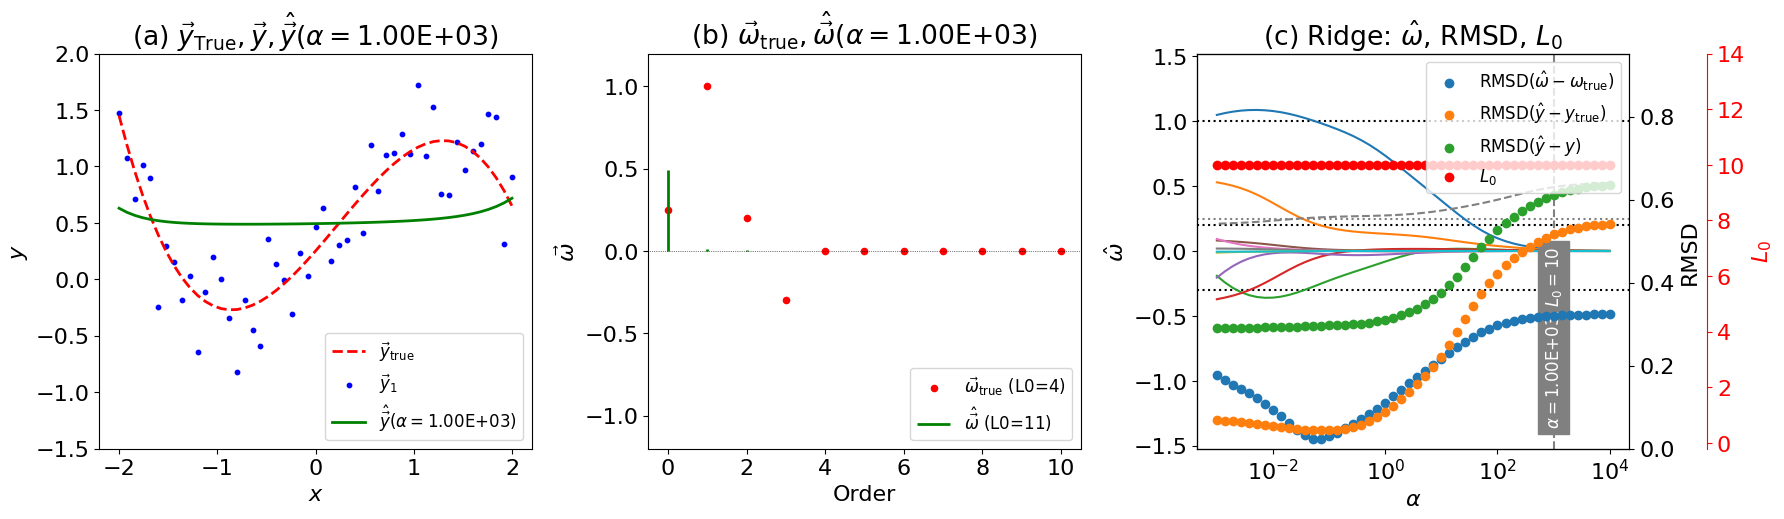

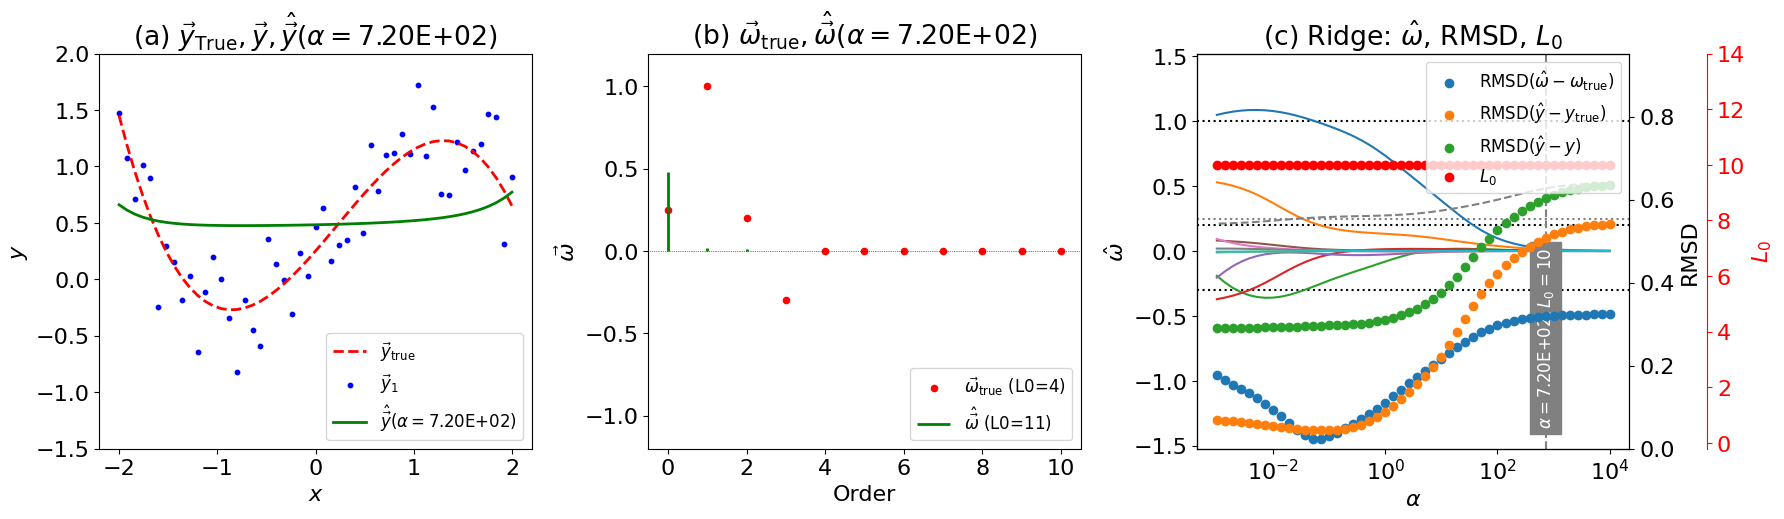

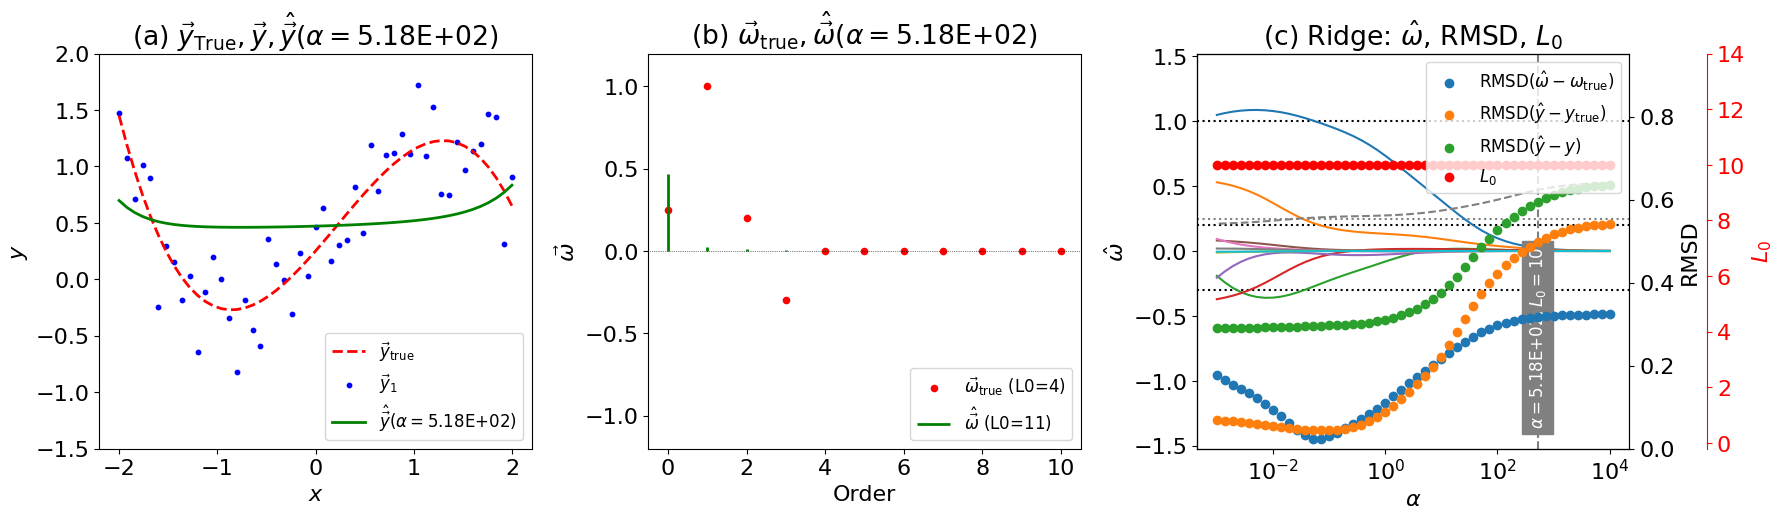

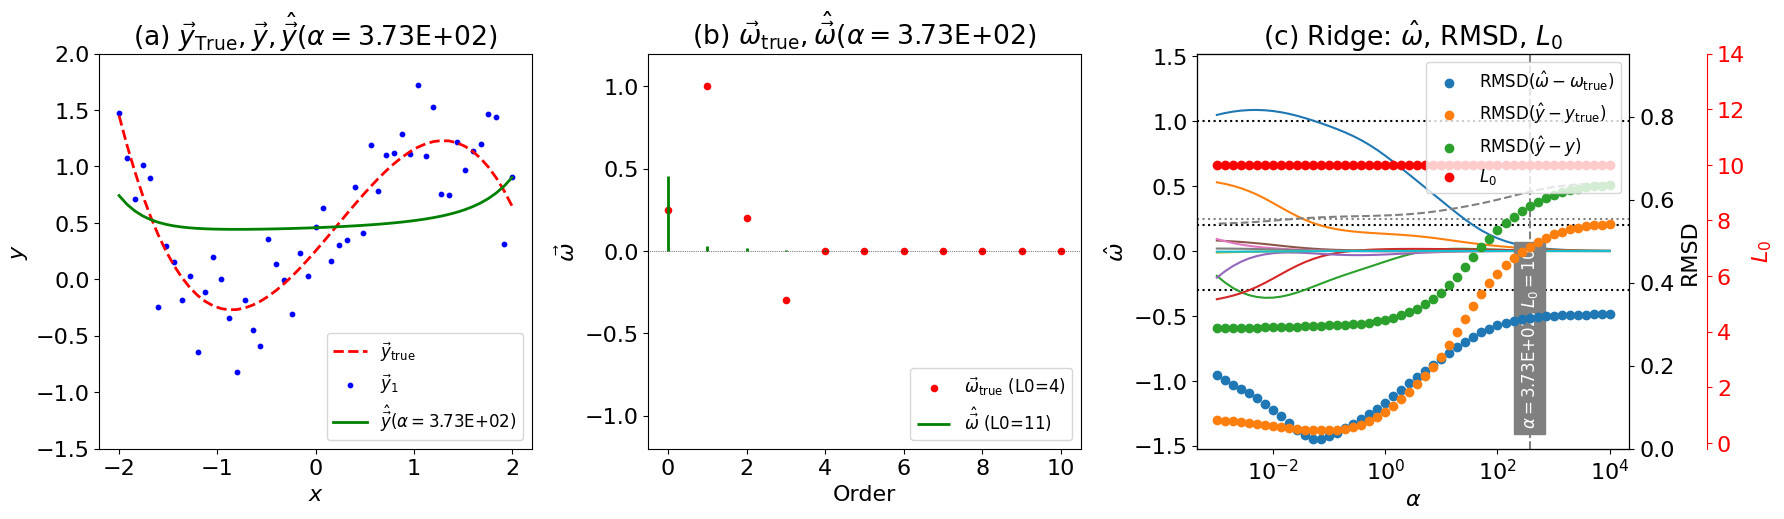

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Appendix/ARidge-Polynomial/ARidge-Polynomial-idx10-summary.pdf


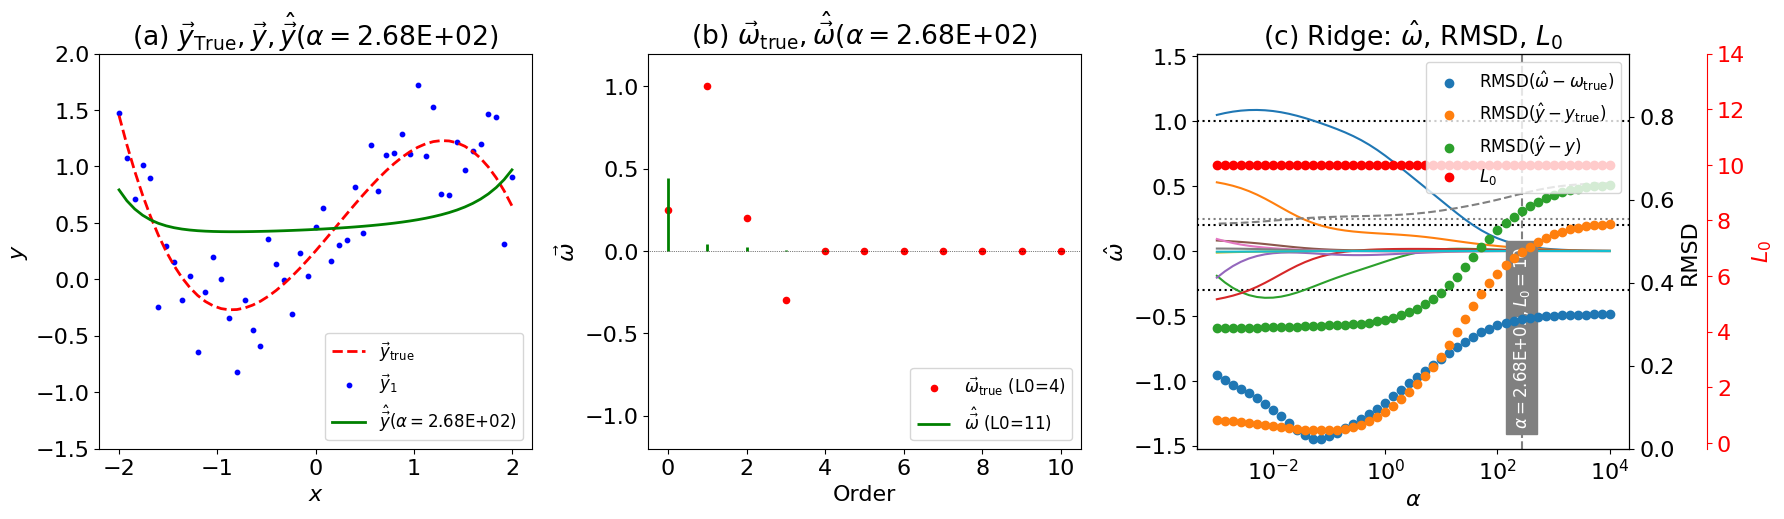

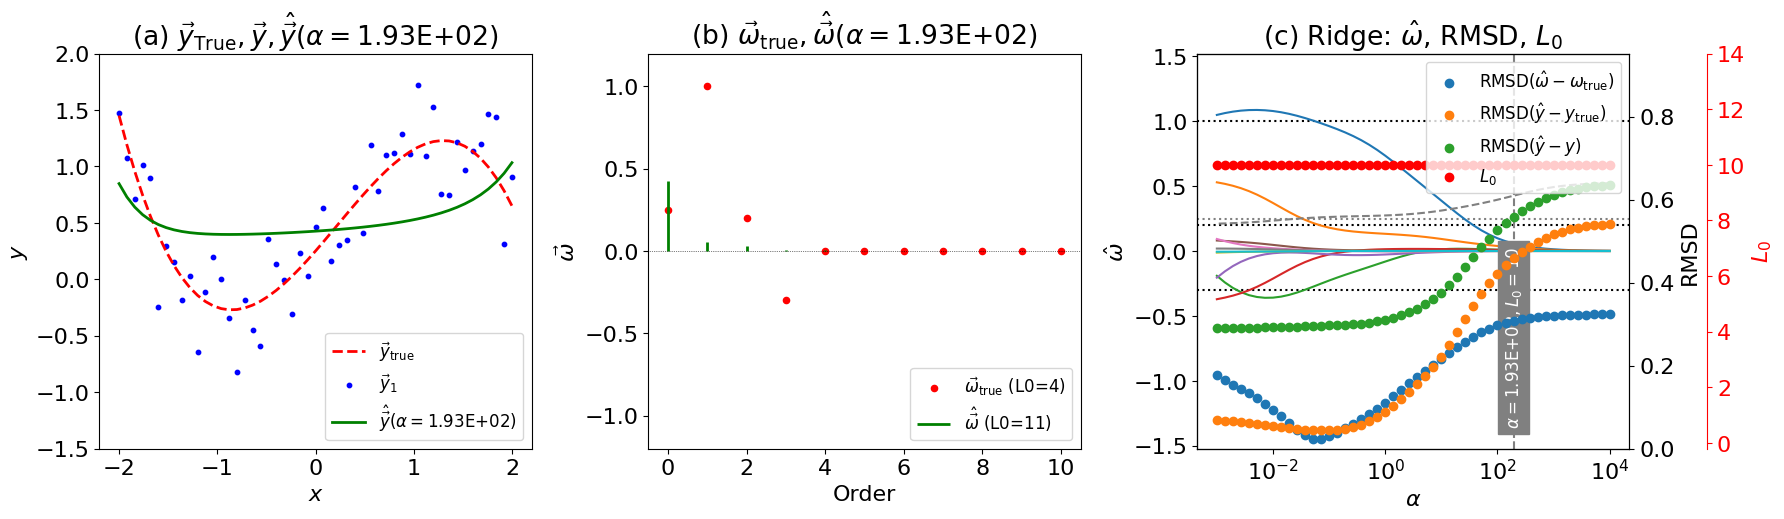

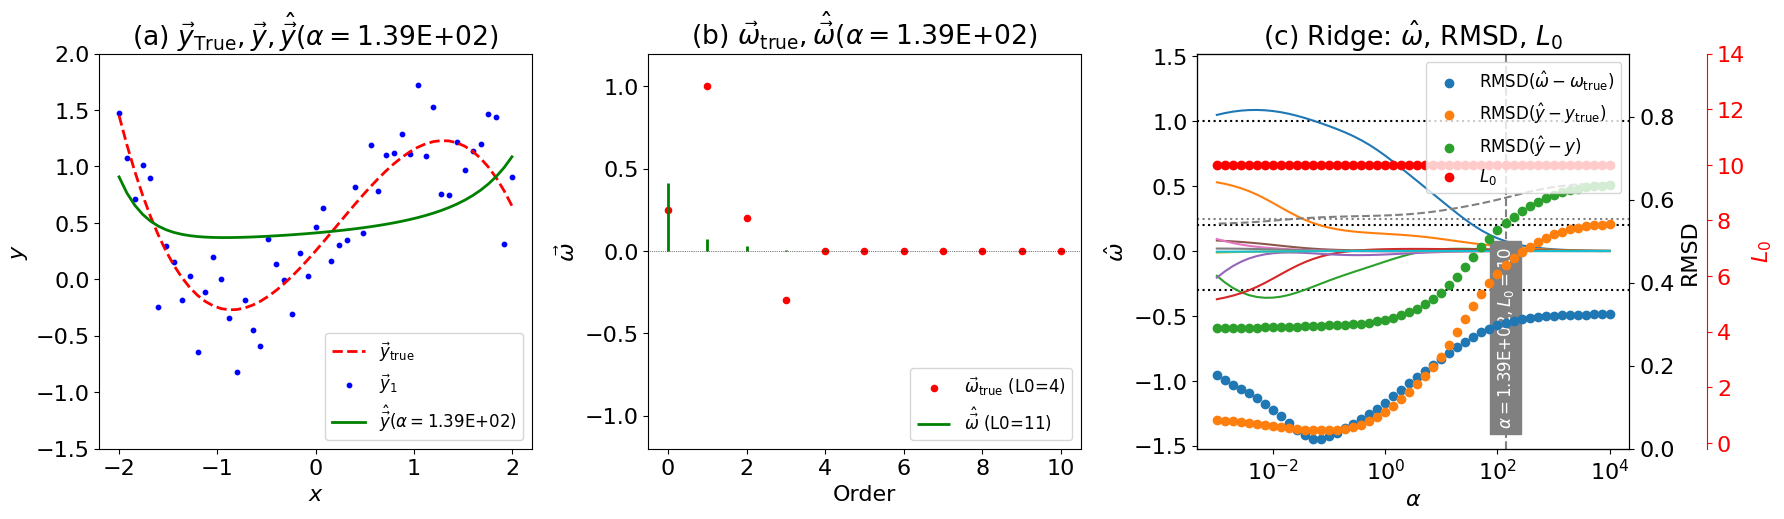

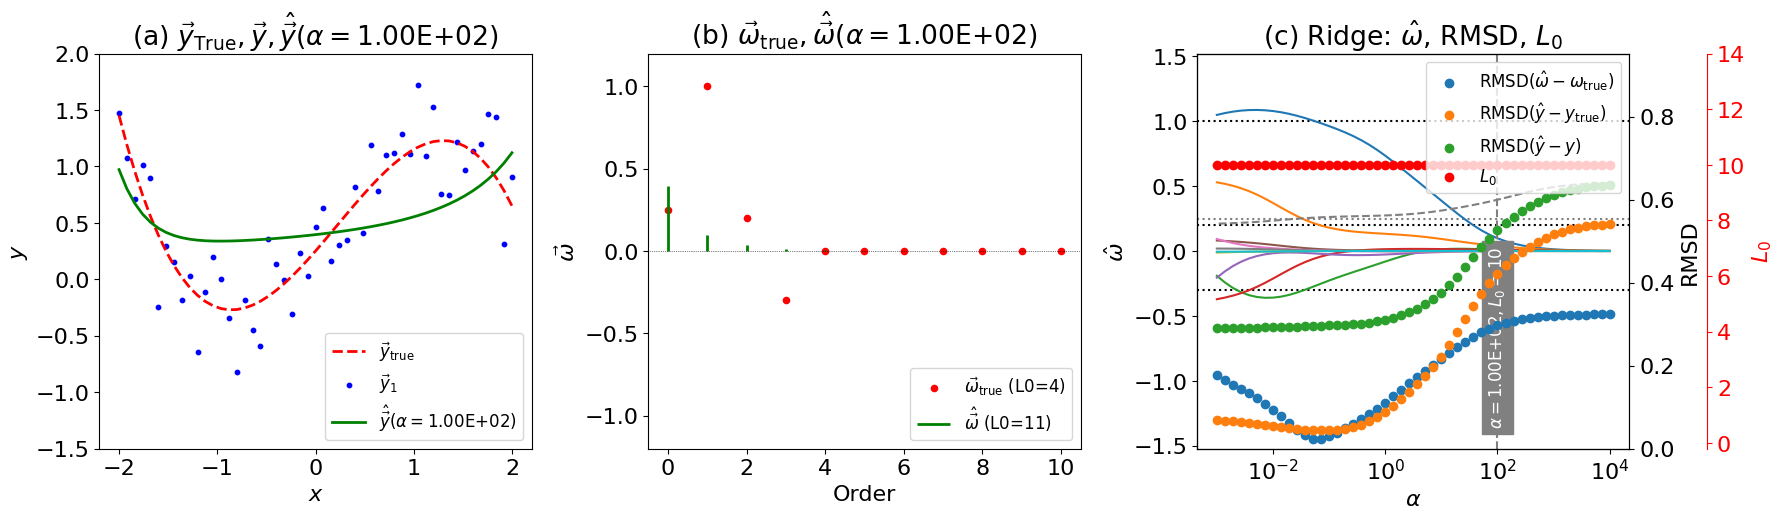

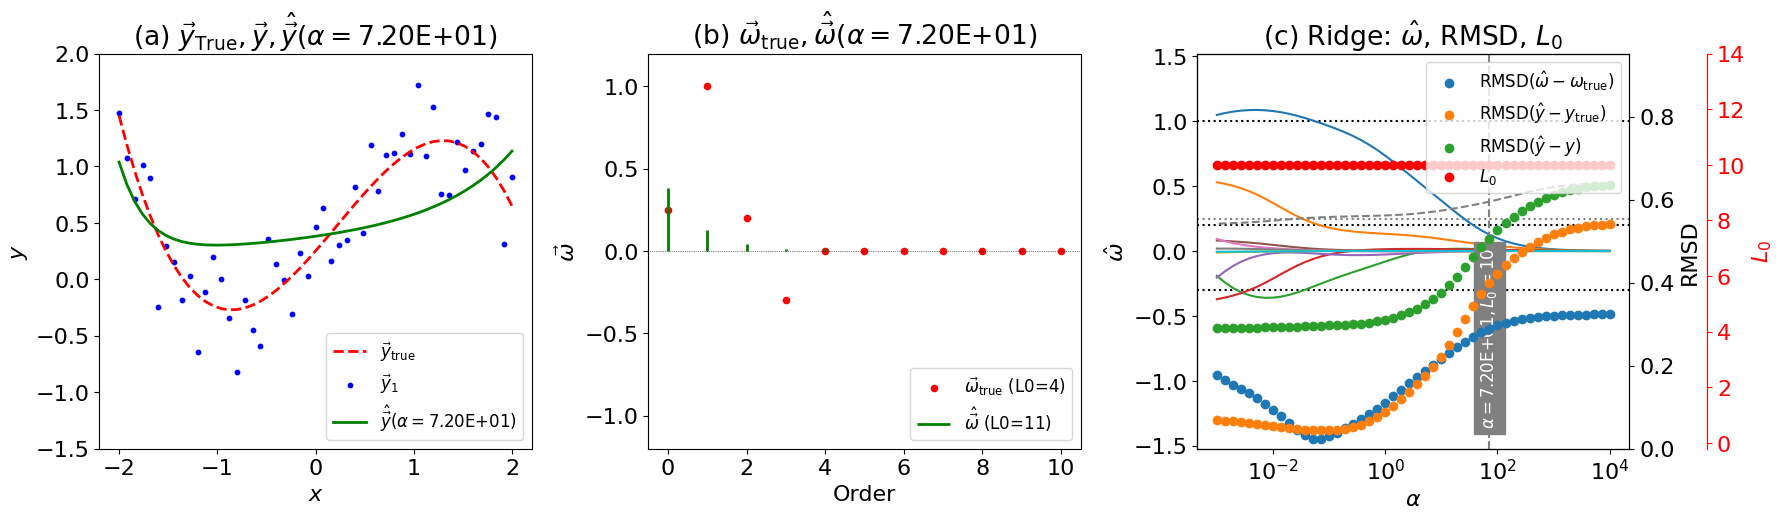

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Appendix/ARidge-Polynomial/ARidge-Polynomial-idx15-summary.pdf


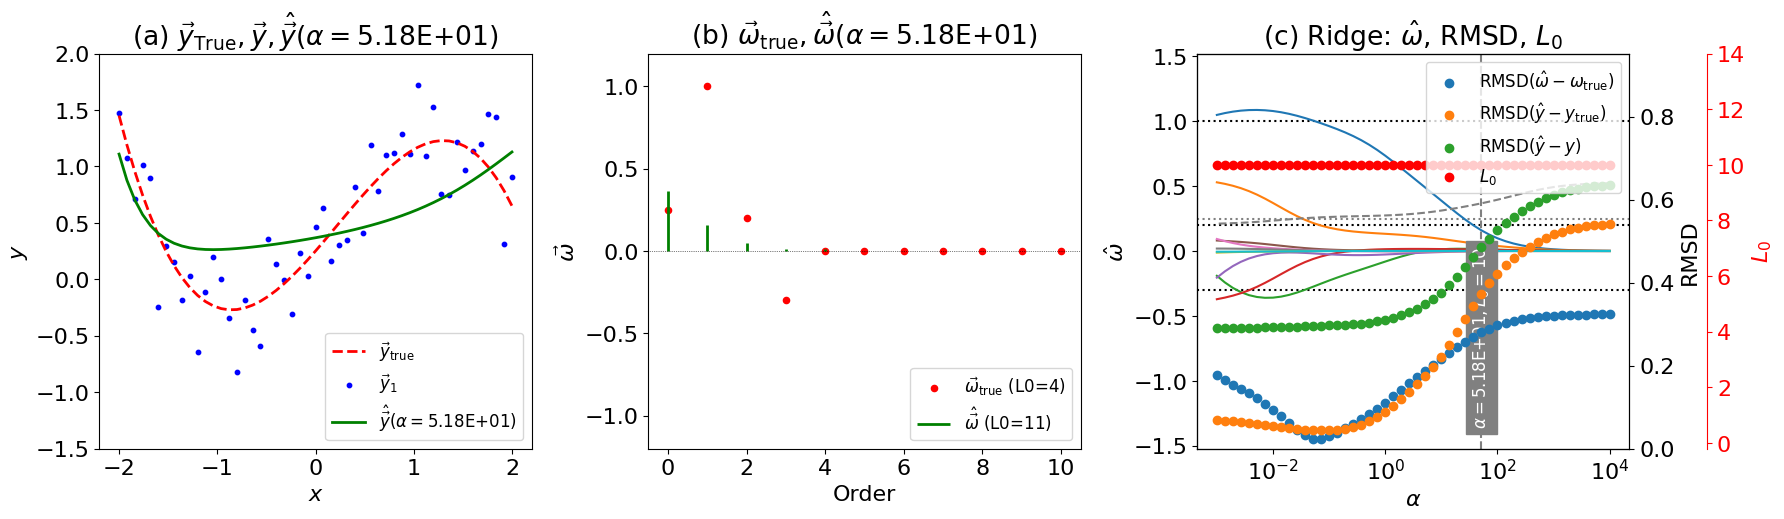

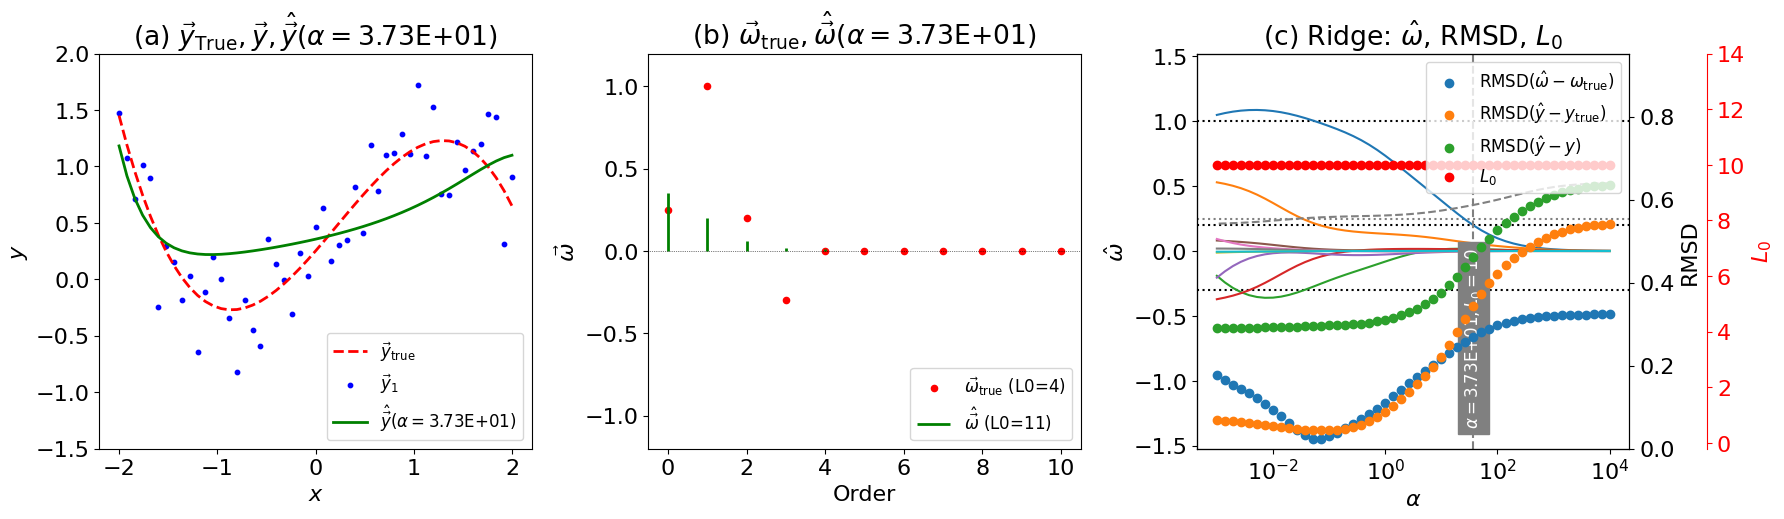

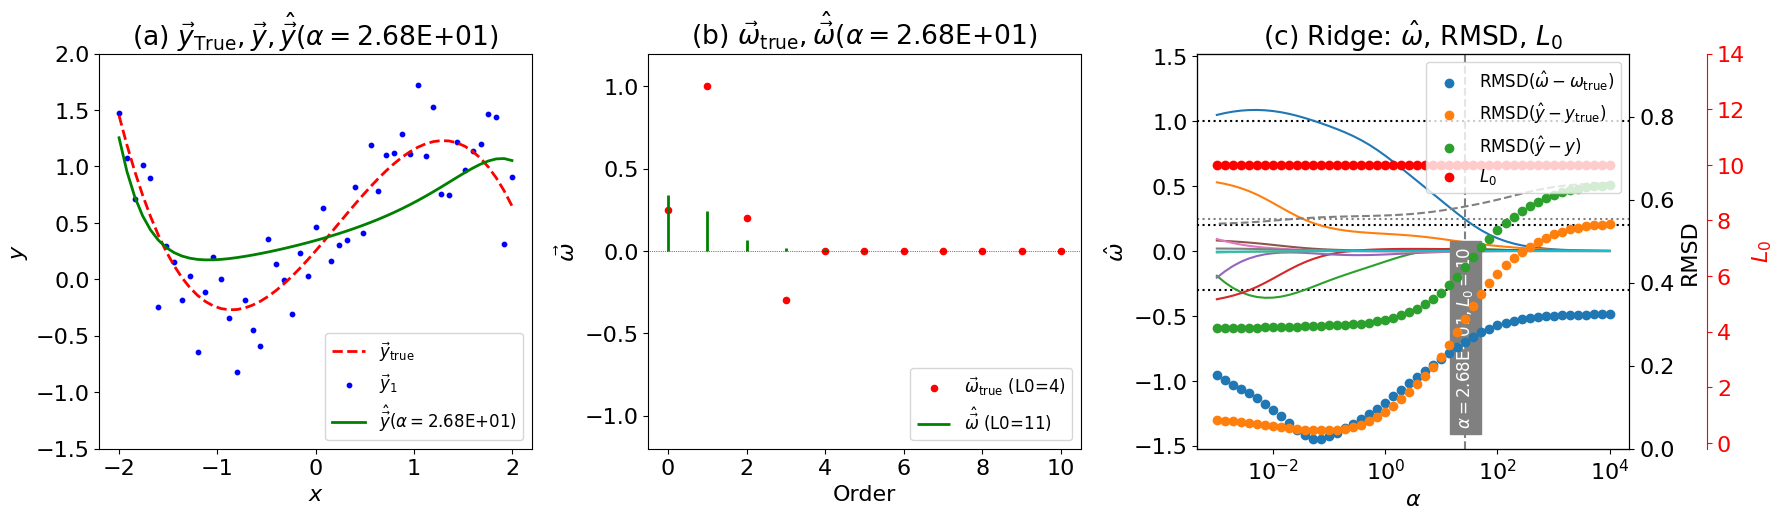

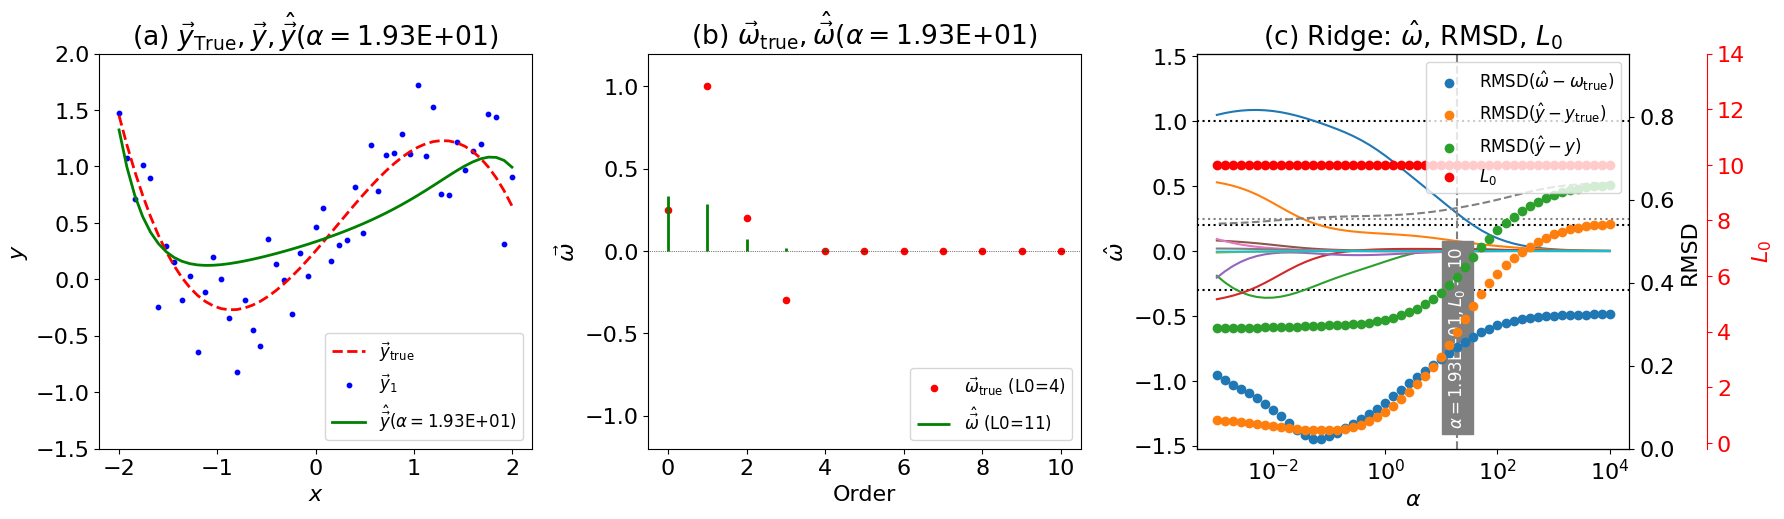

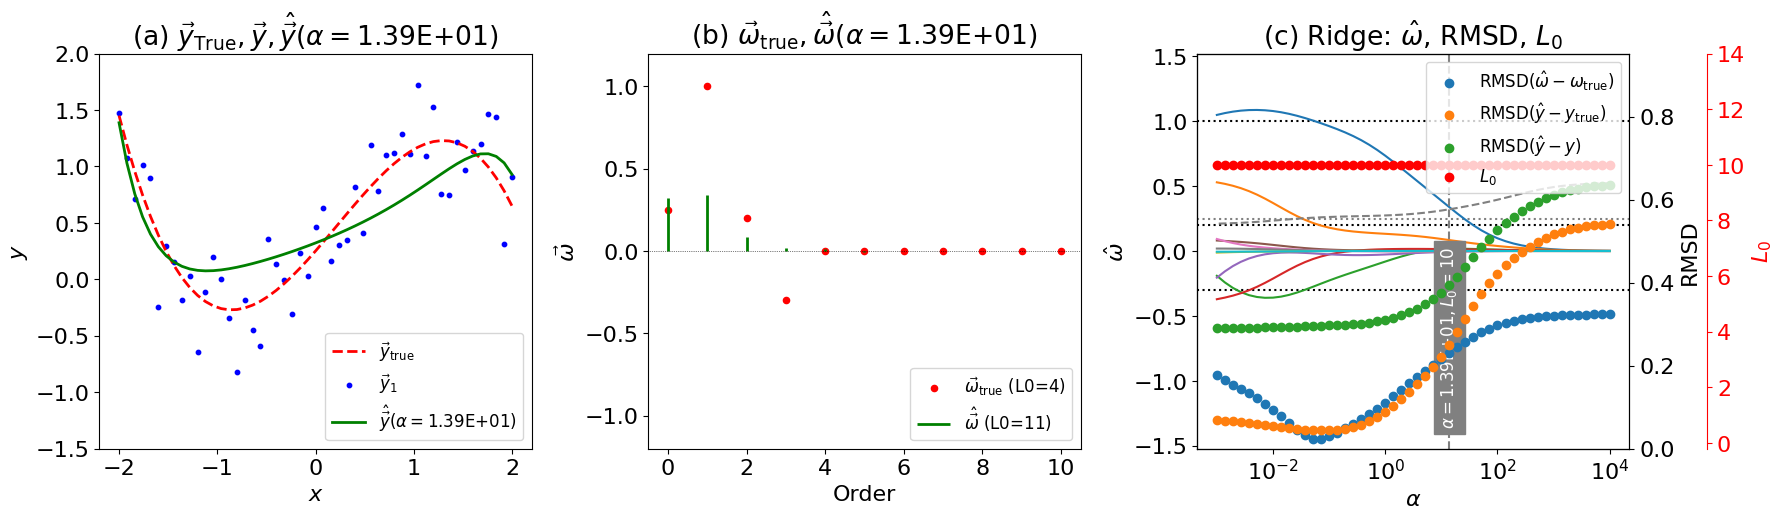

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Appendix/ARidge-Polynomial/ARidge-Polynomial-idx20-summary.pdf


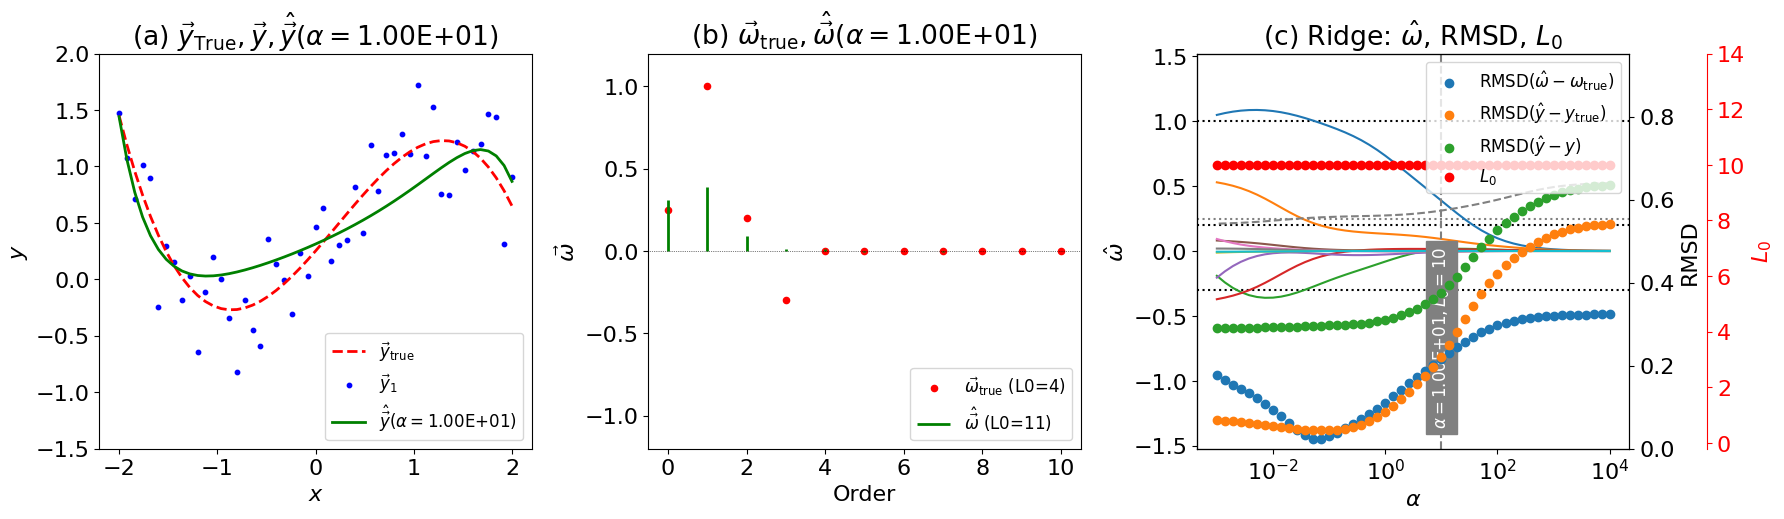

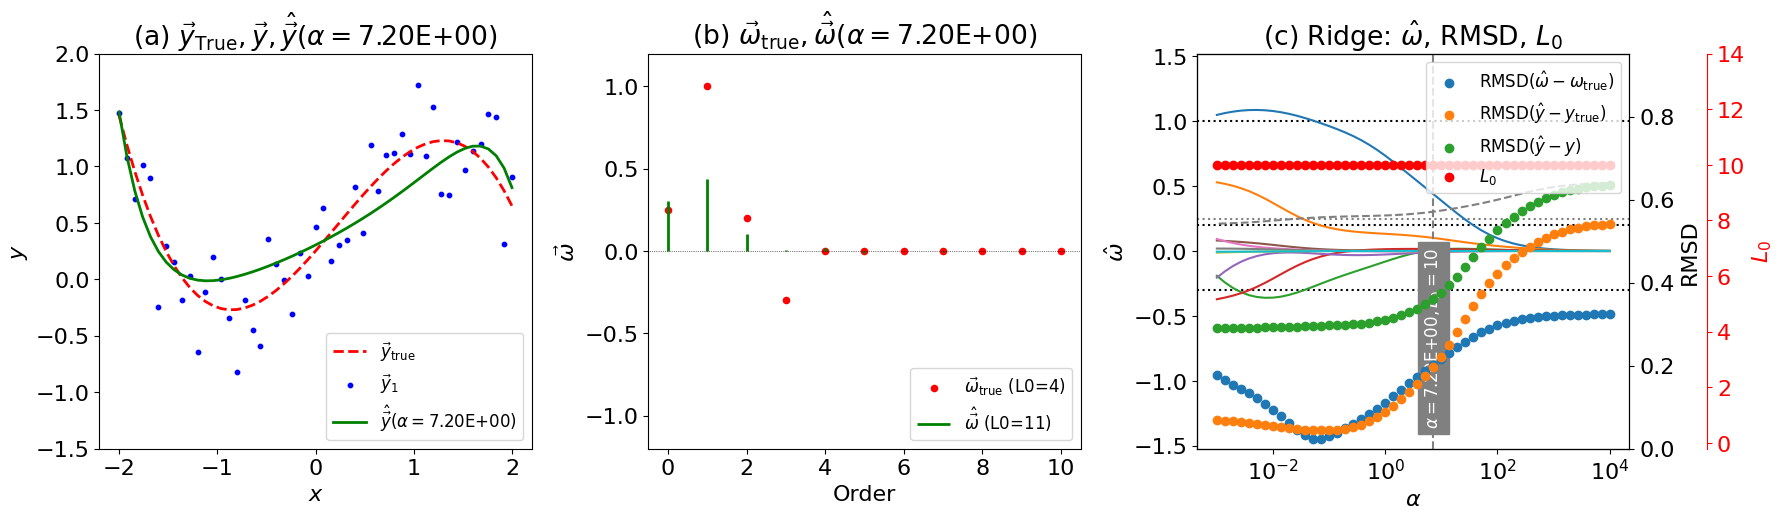

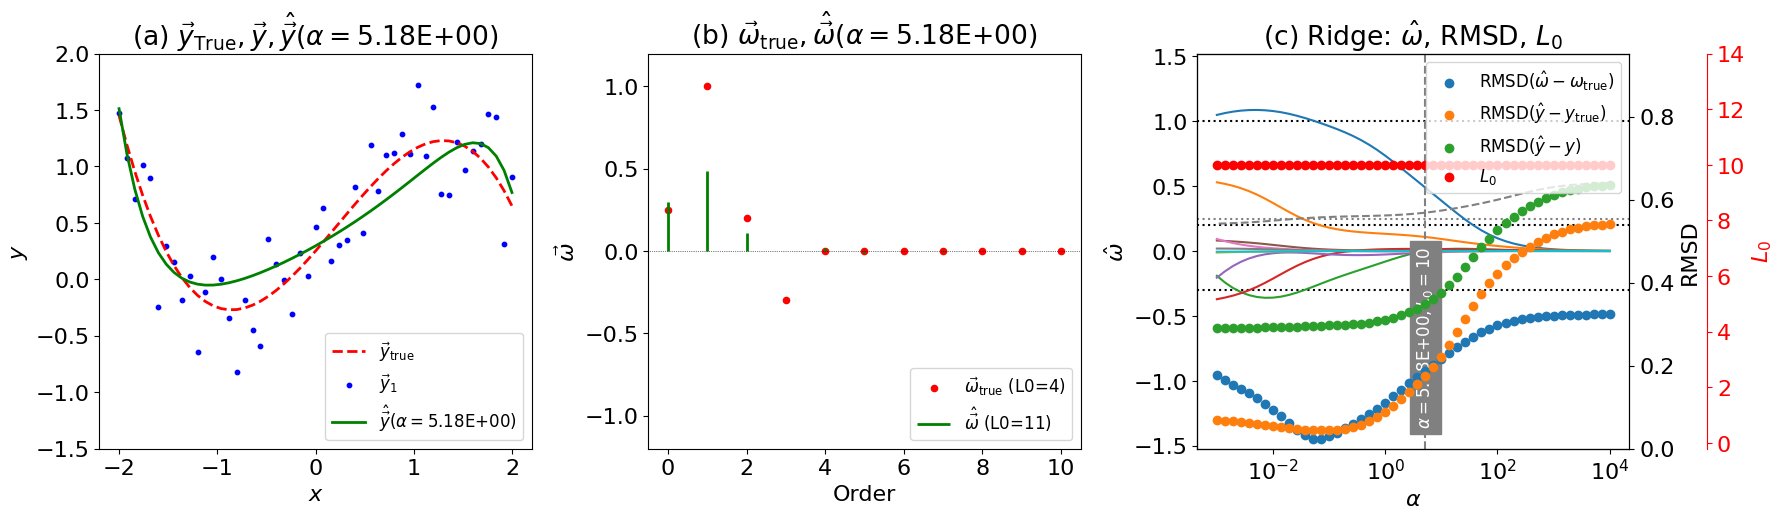

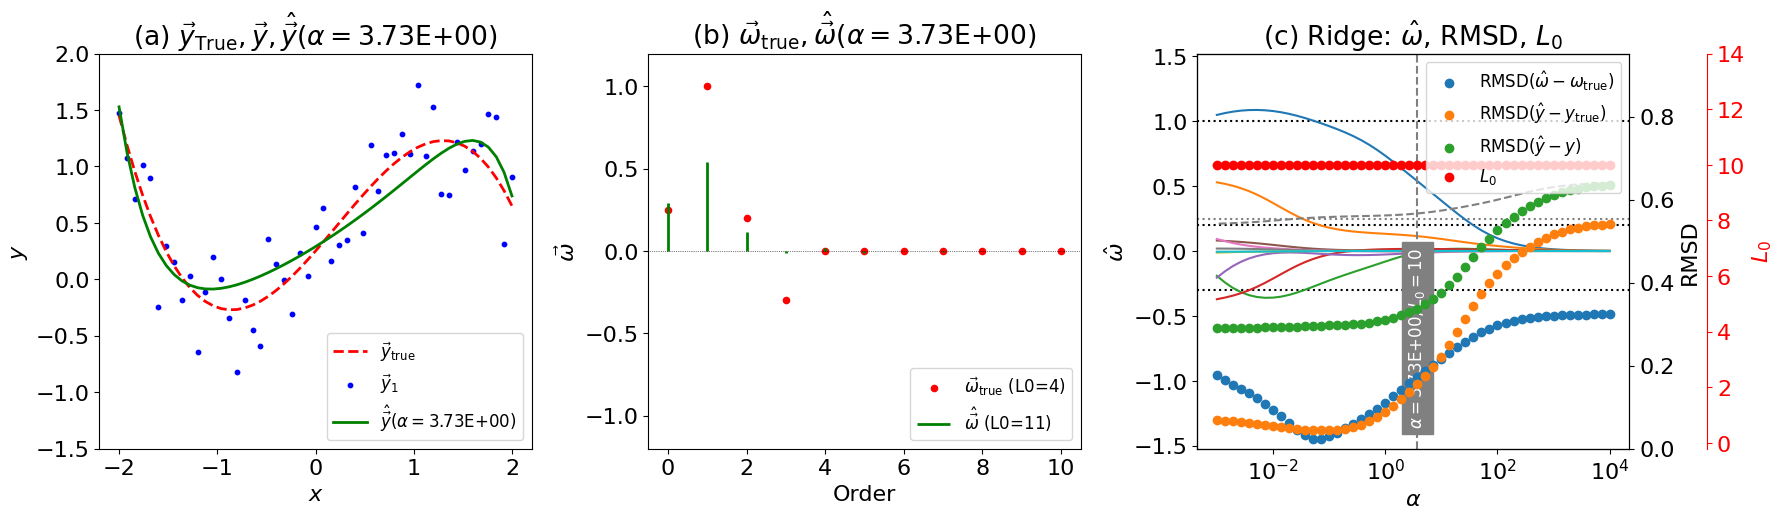

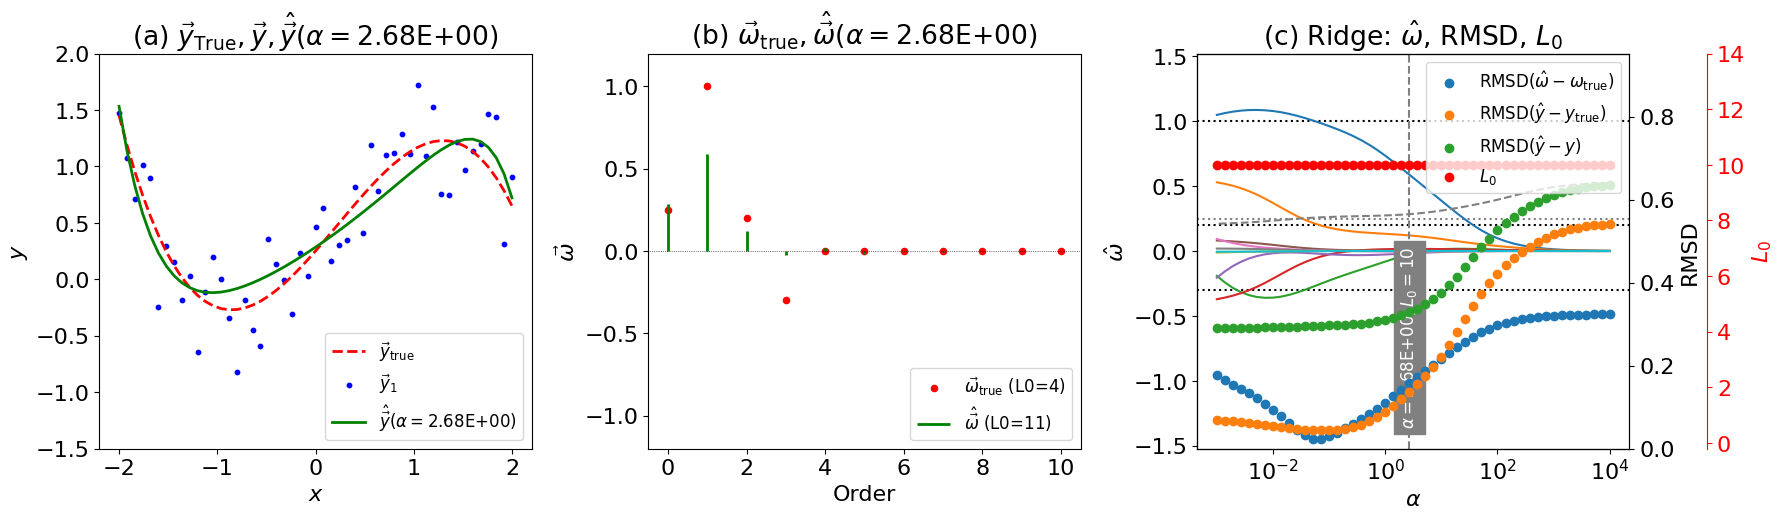

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Appendix/ARidge-Polynomial/ARidge-Polynomial-idx25-summary.pdf


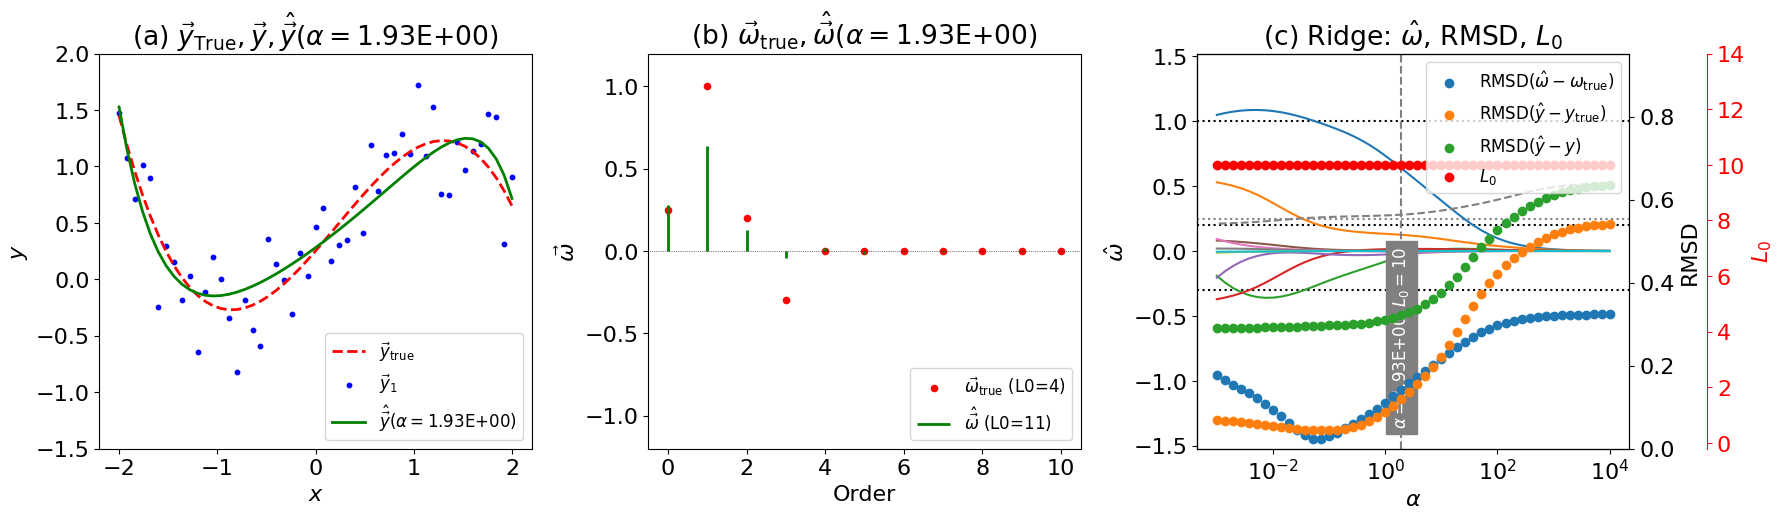

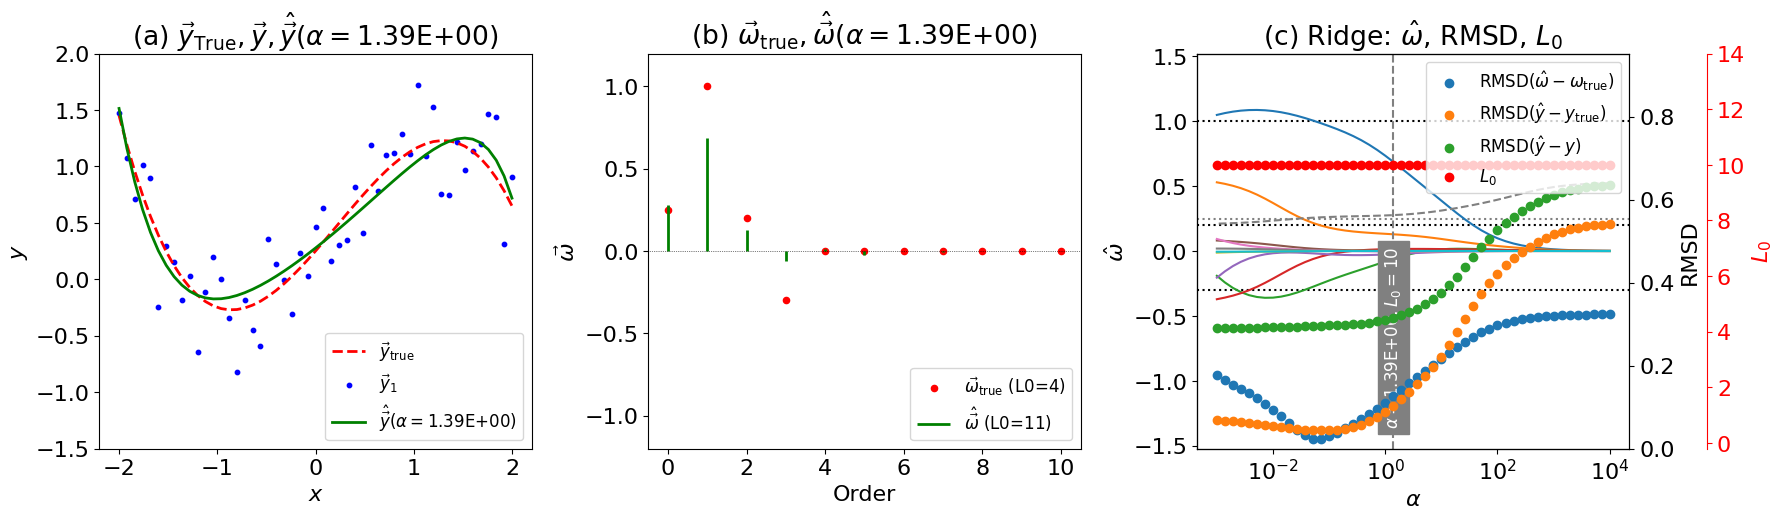

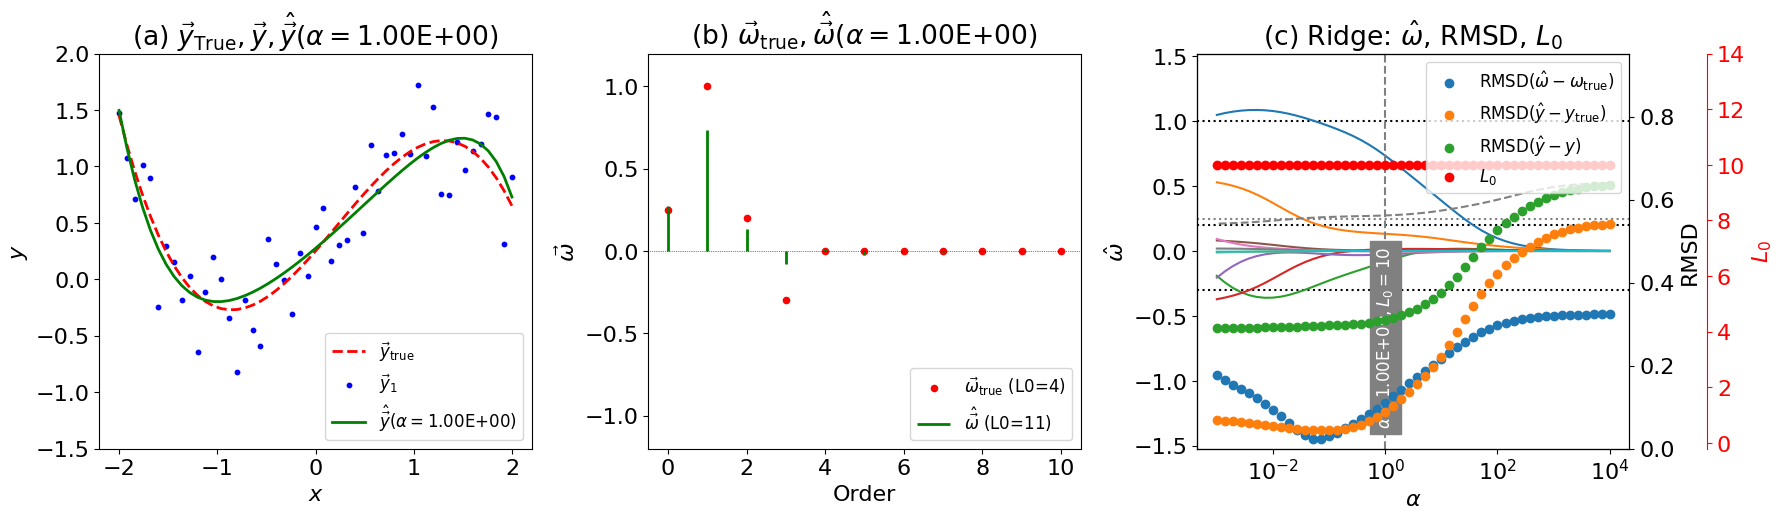

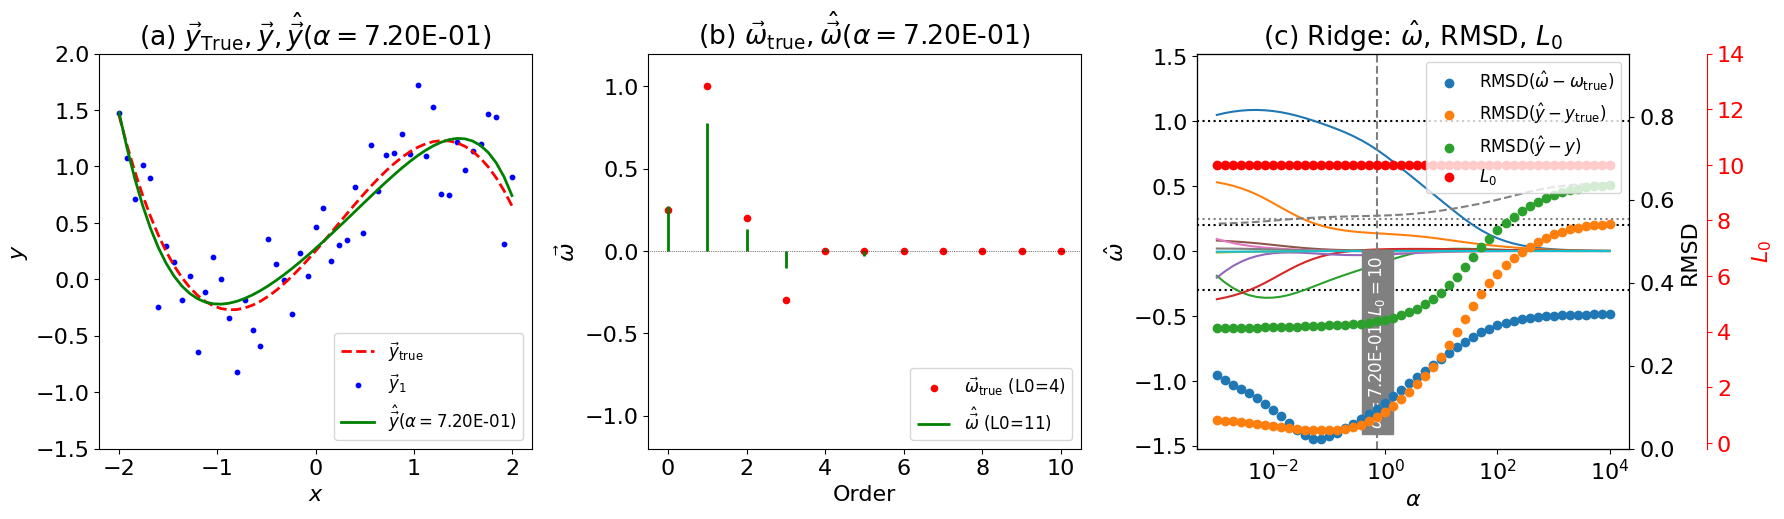

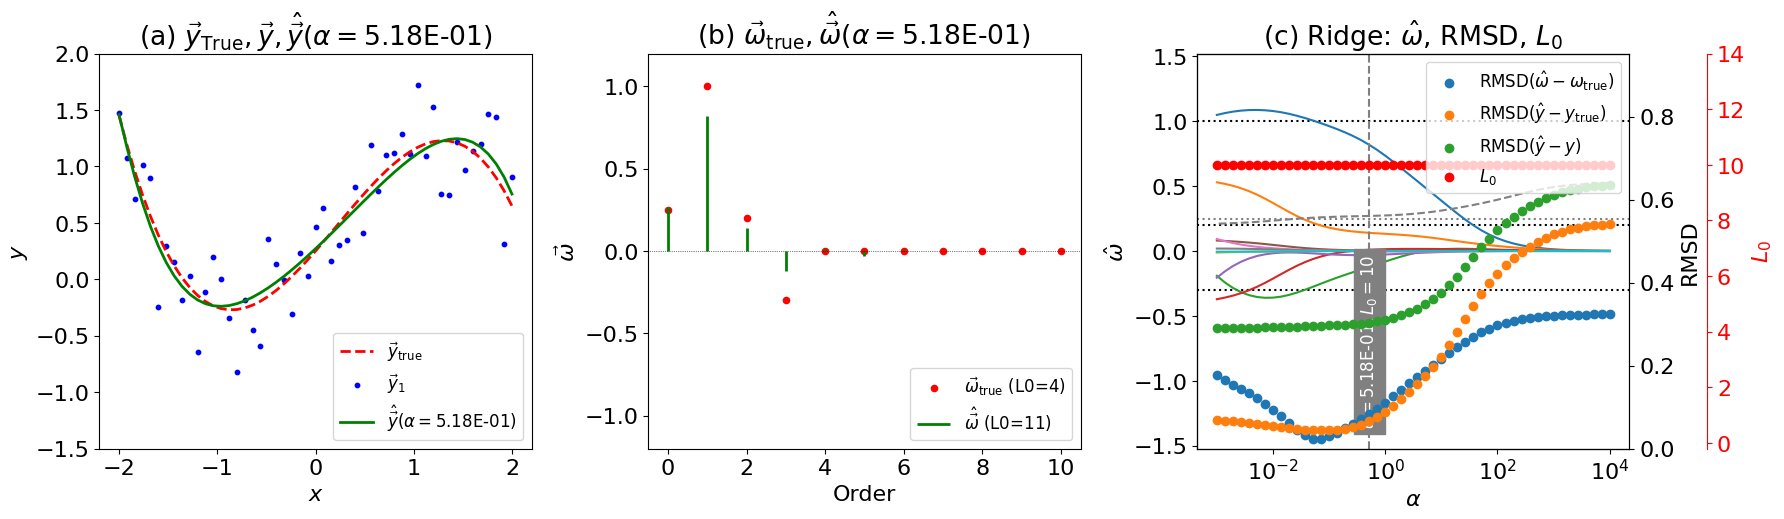

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Appendix/ARidge-Polynomial/ARidge-Polynomial-idx30-summary.pdf


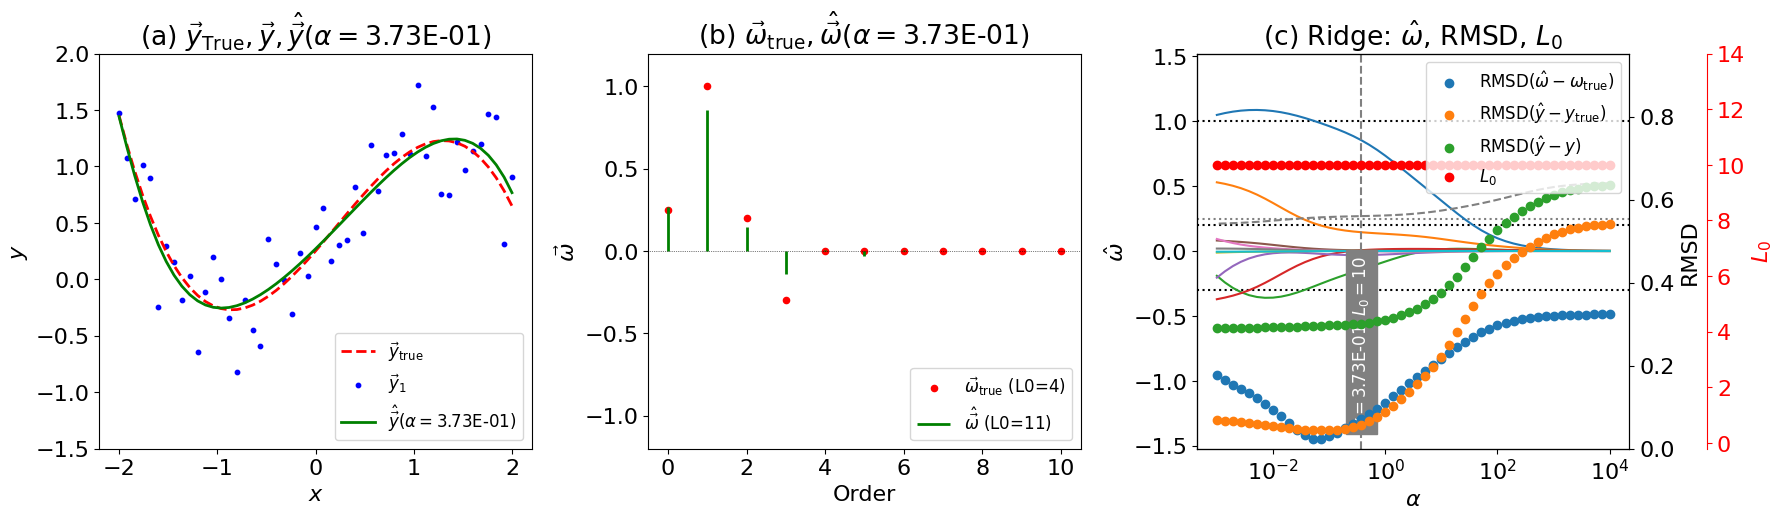

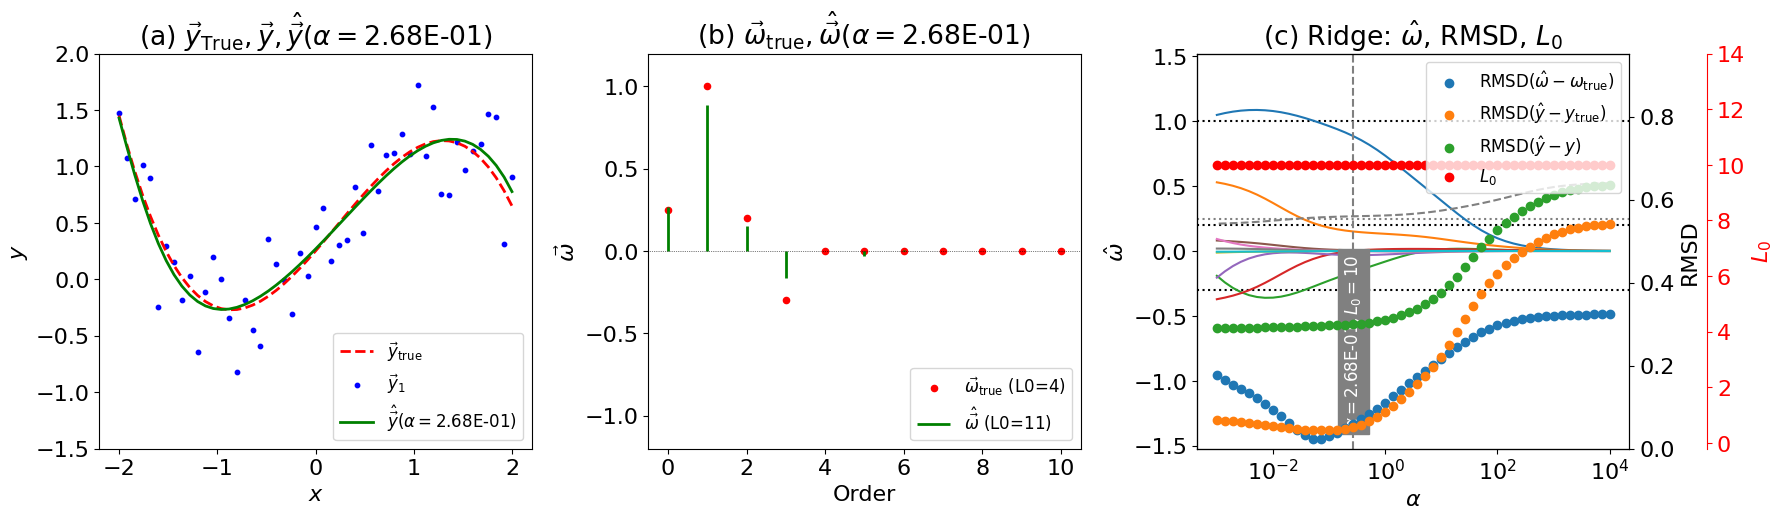

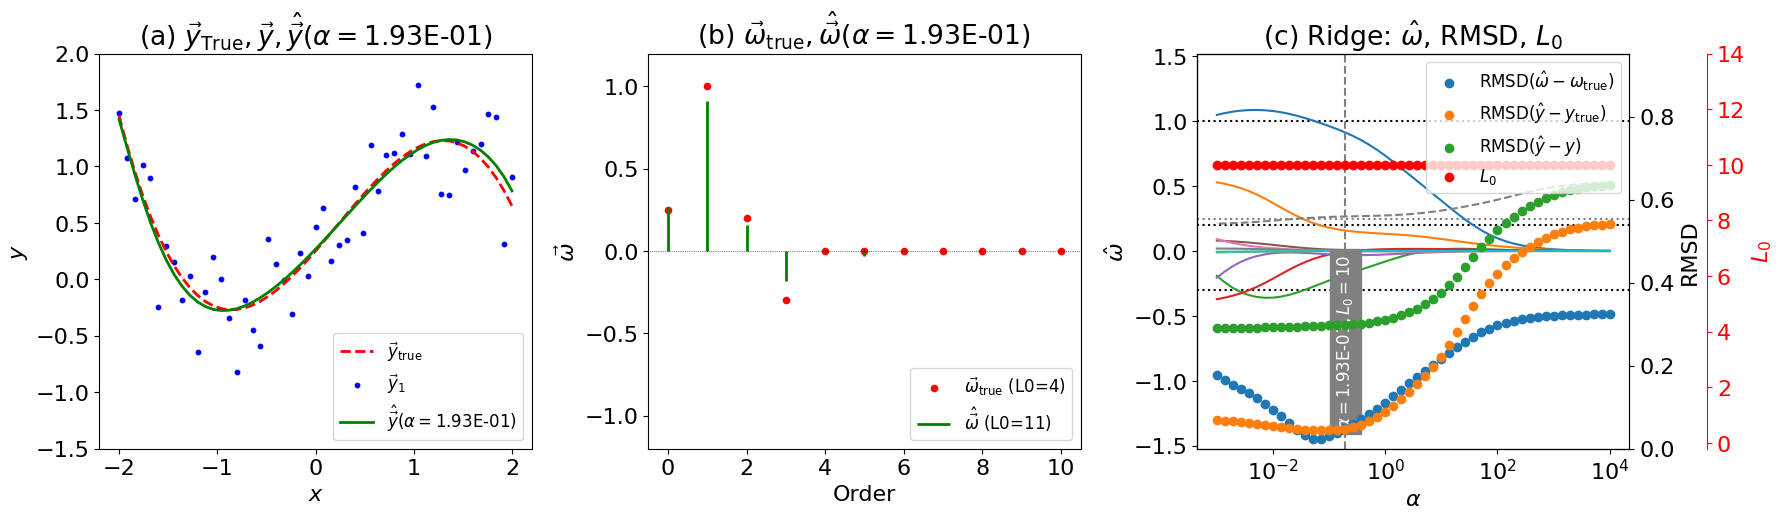

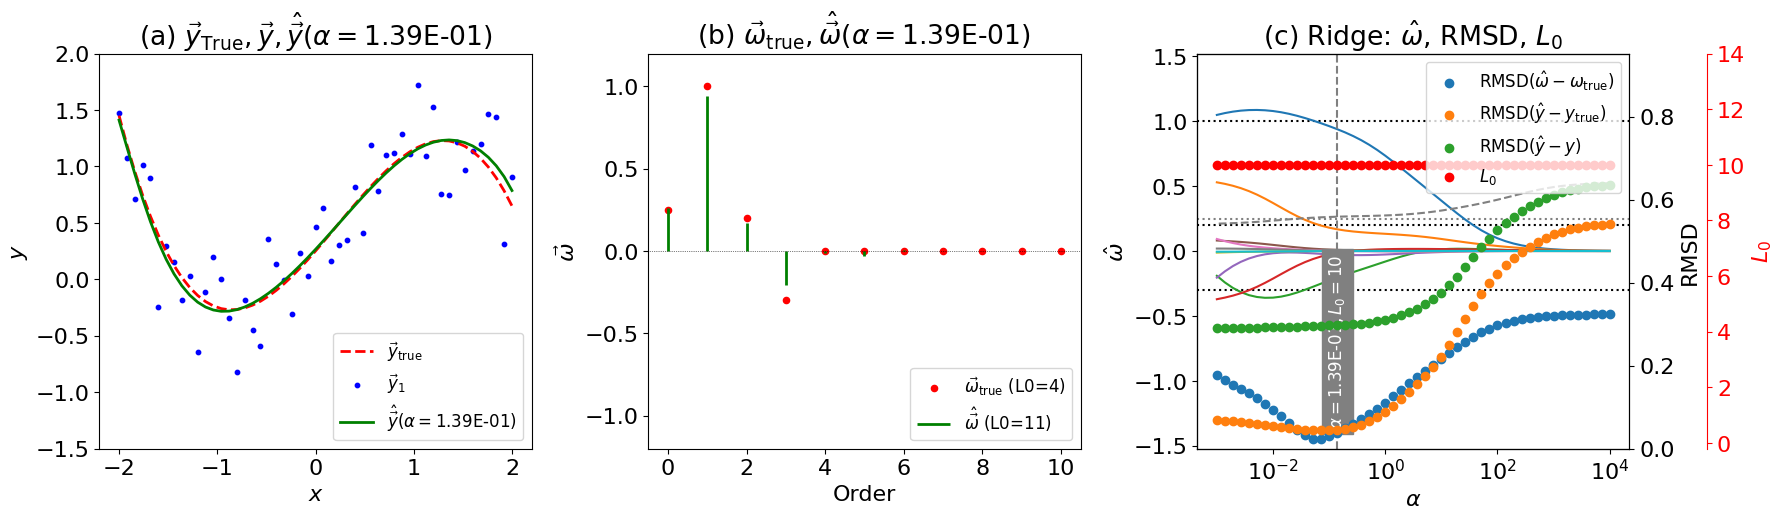

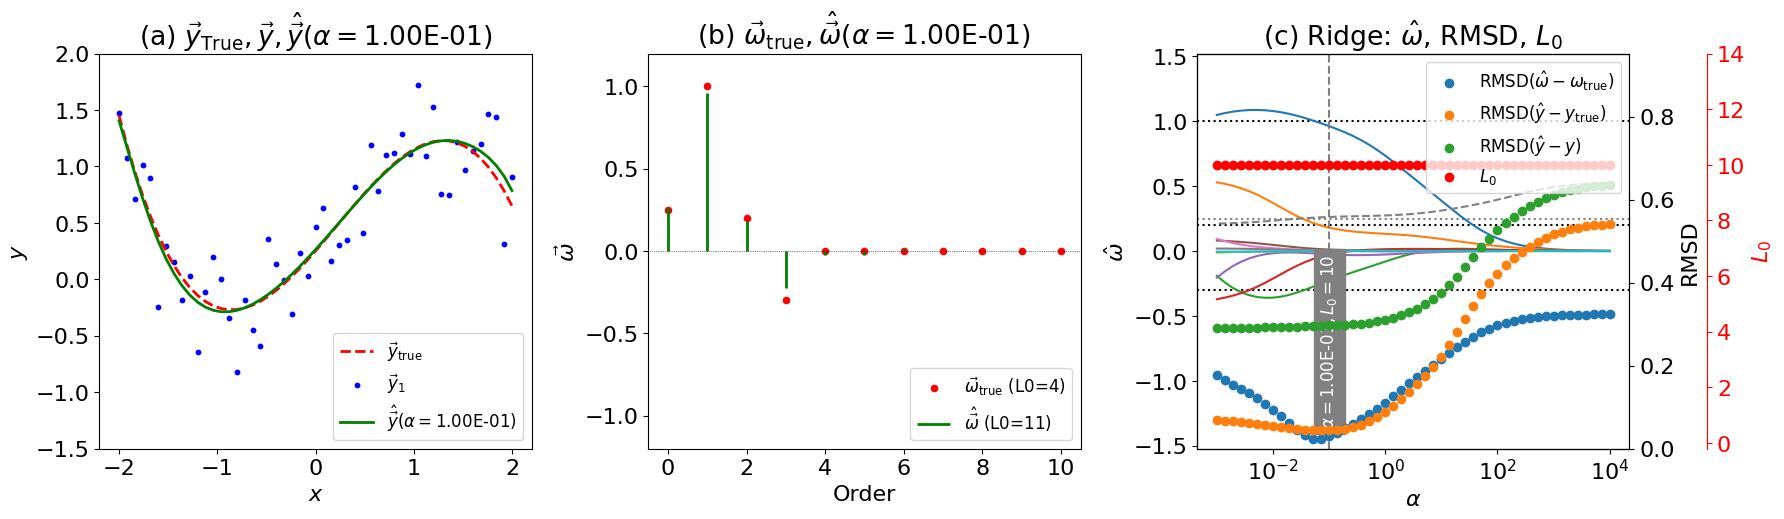

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Appendix/ARidge-Polynomial/ARidge-Polynomial-idx35-summary.pdf


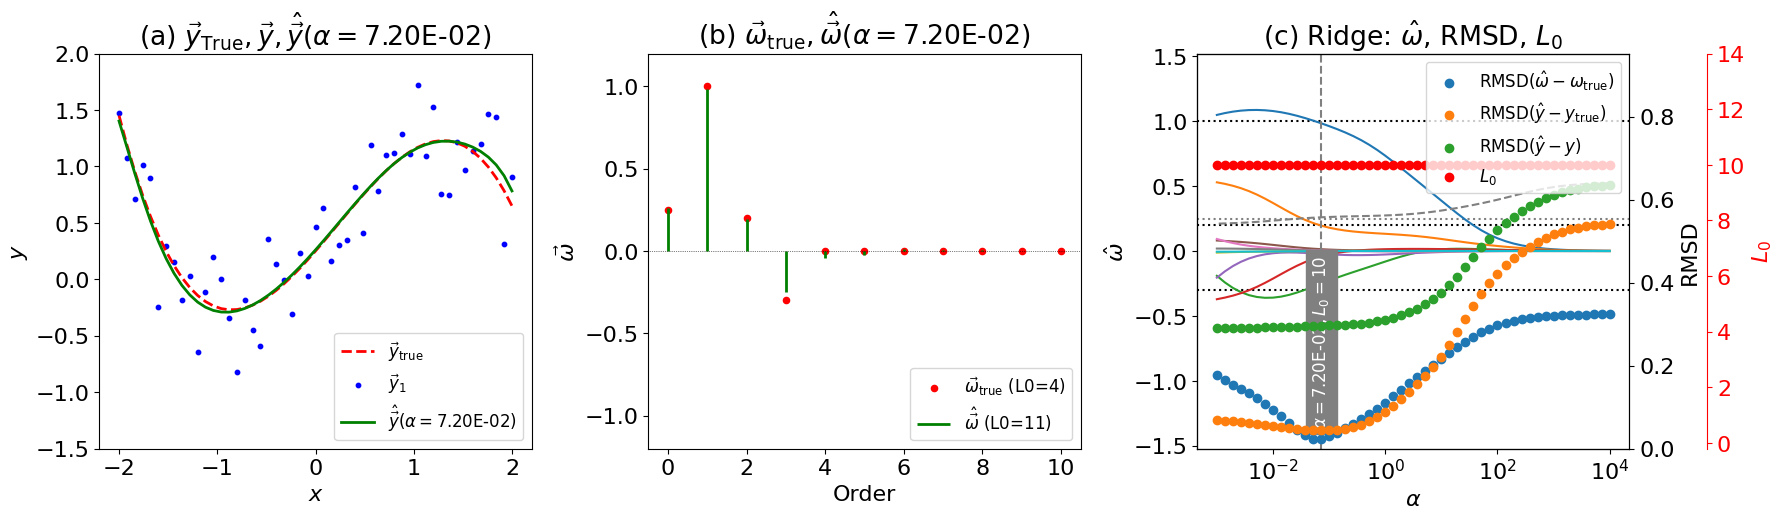

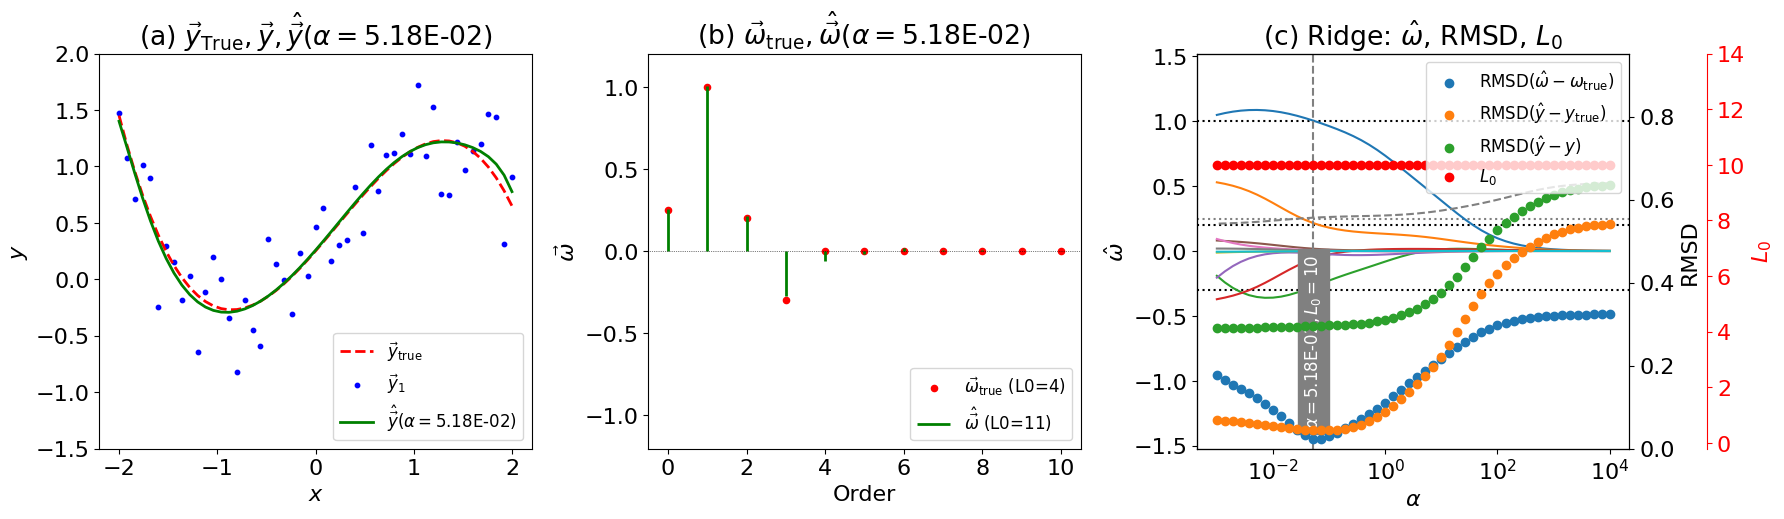

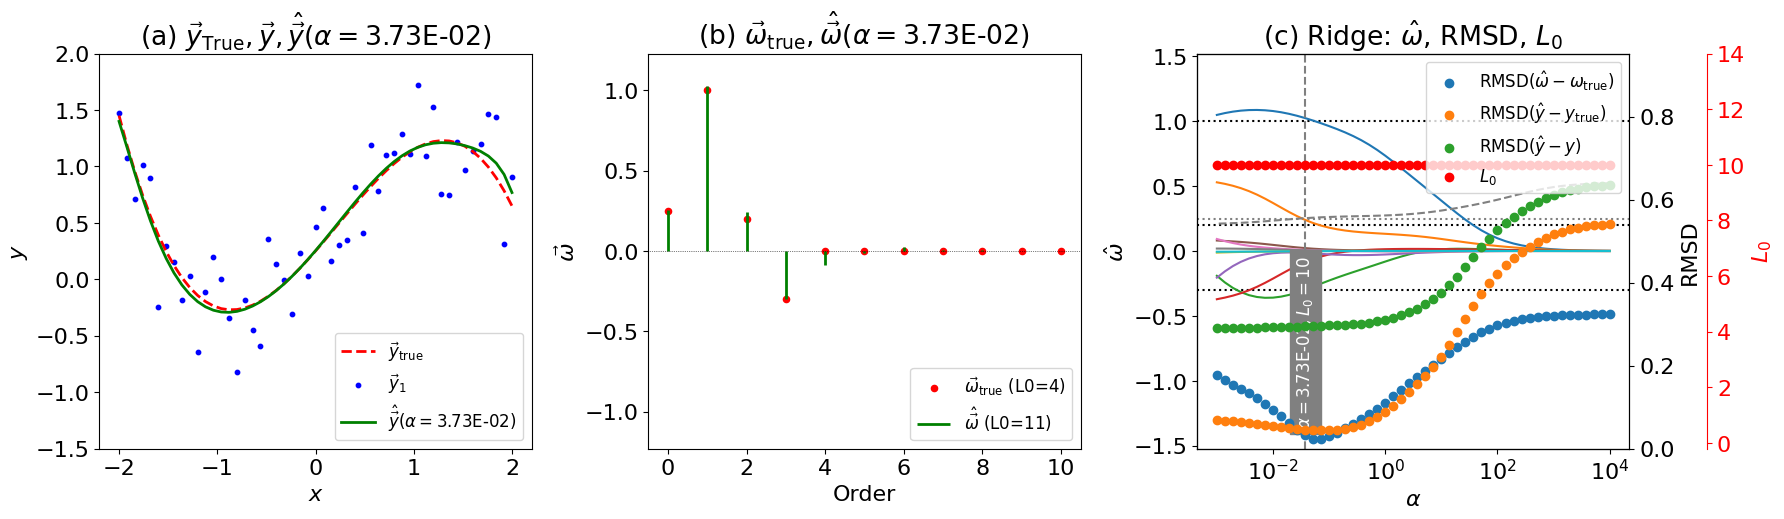

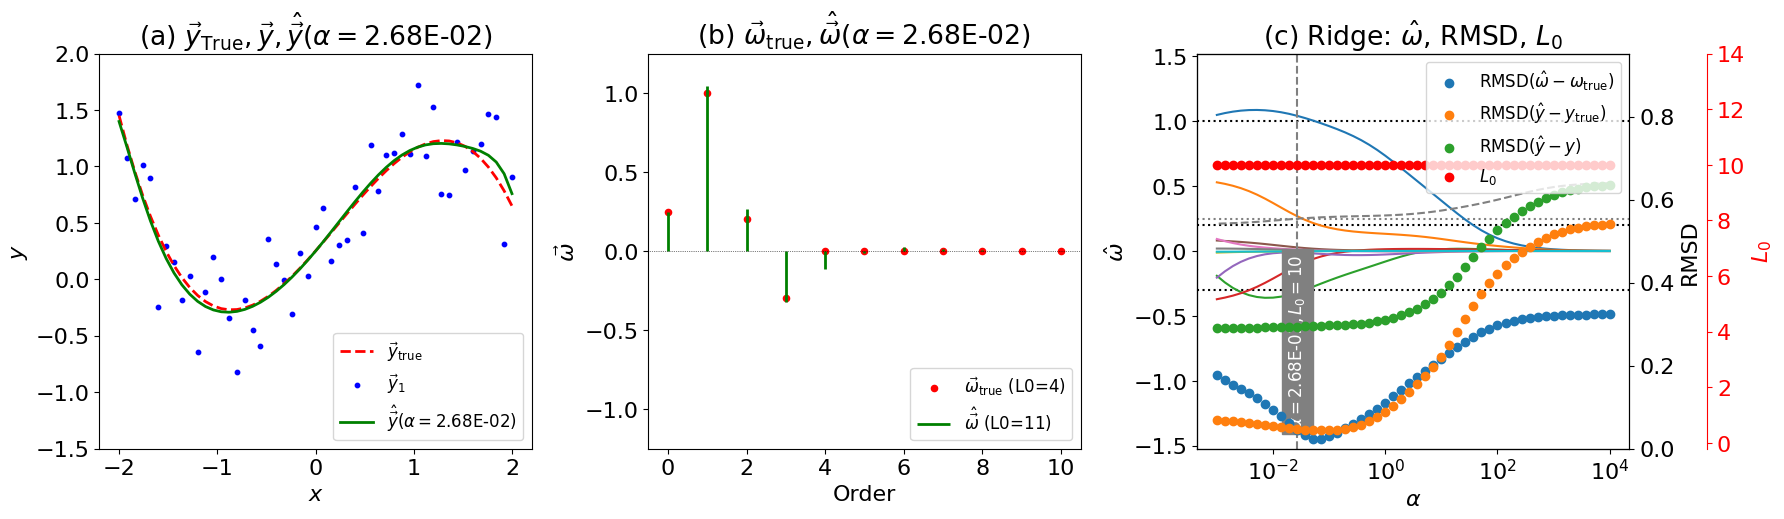

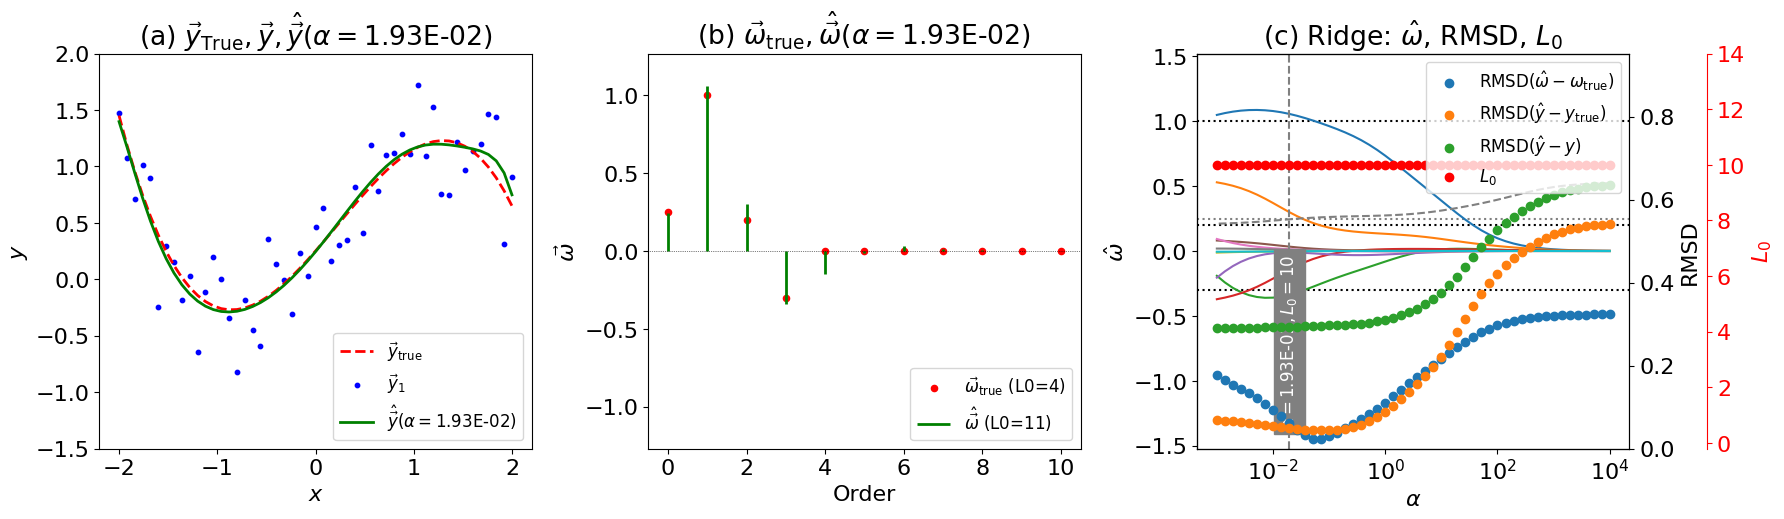

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Appendix/ARidge-Polynomial/ARidge-Polynomial-idx40-summary.pdf


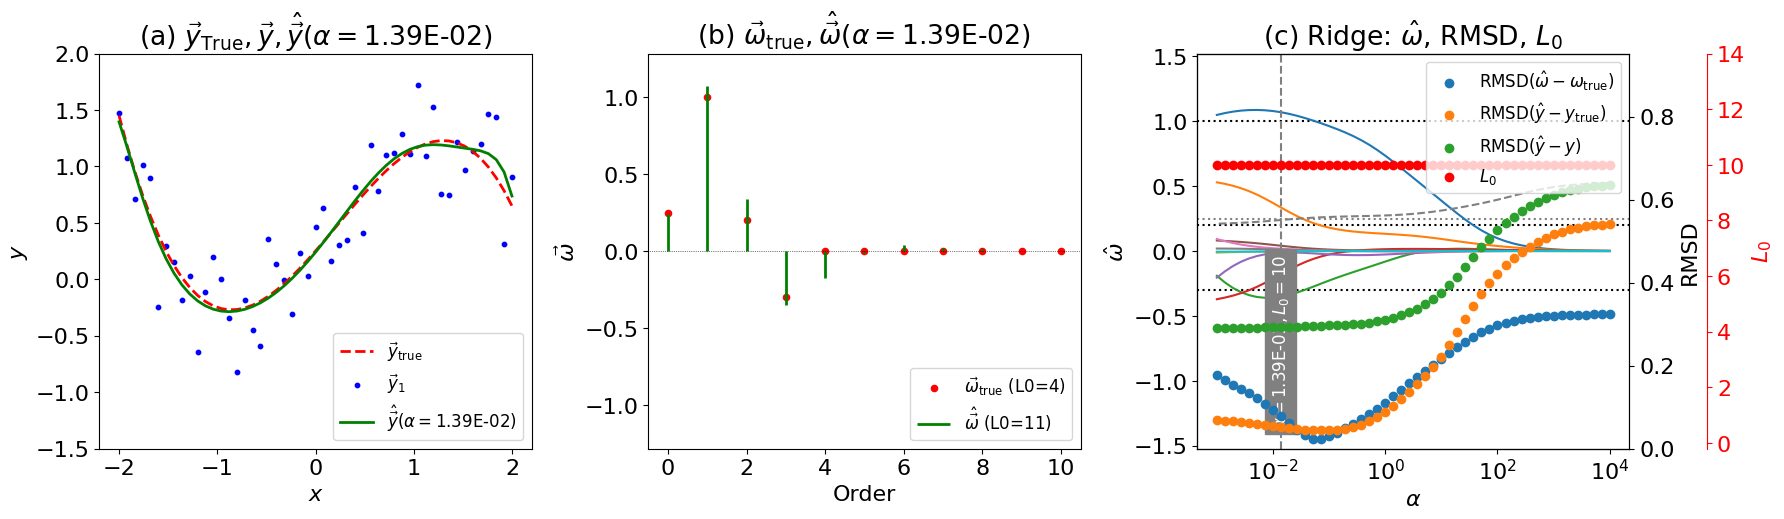

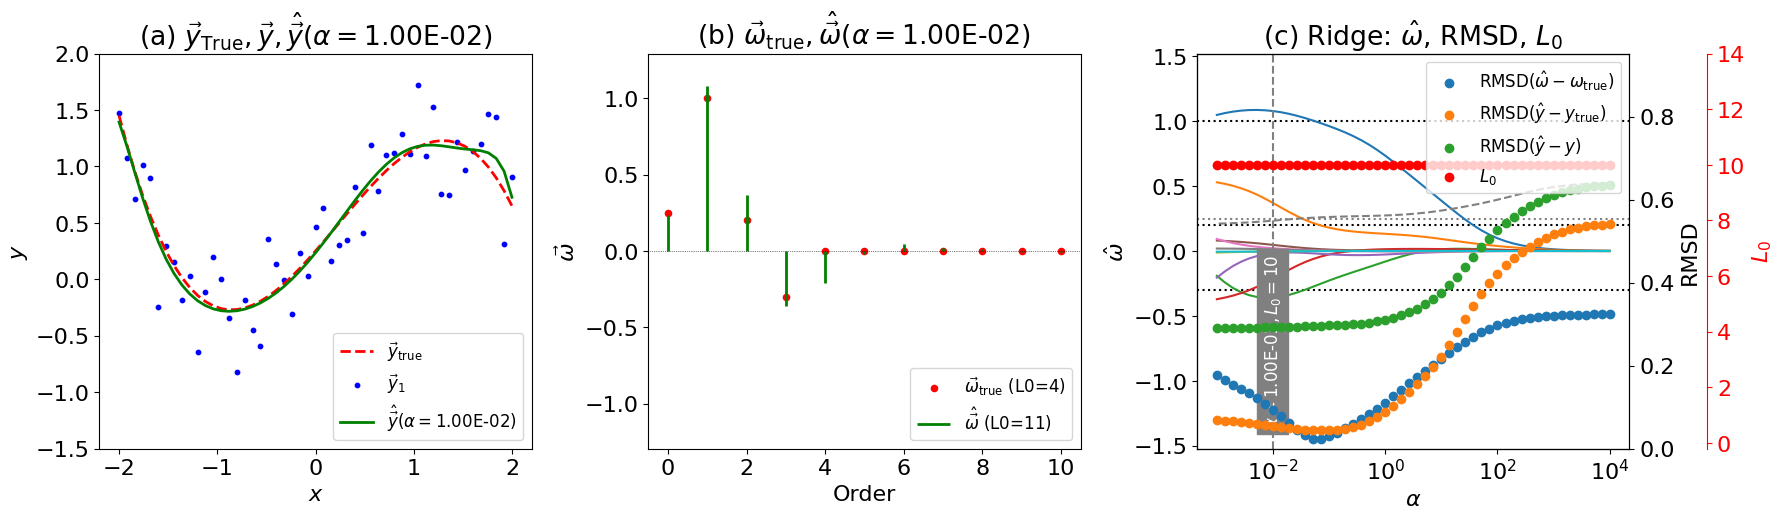

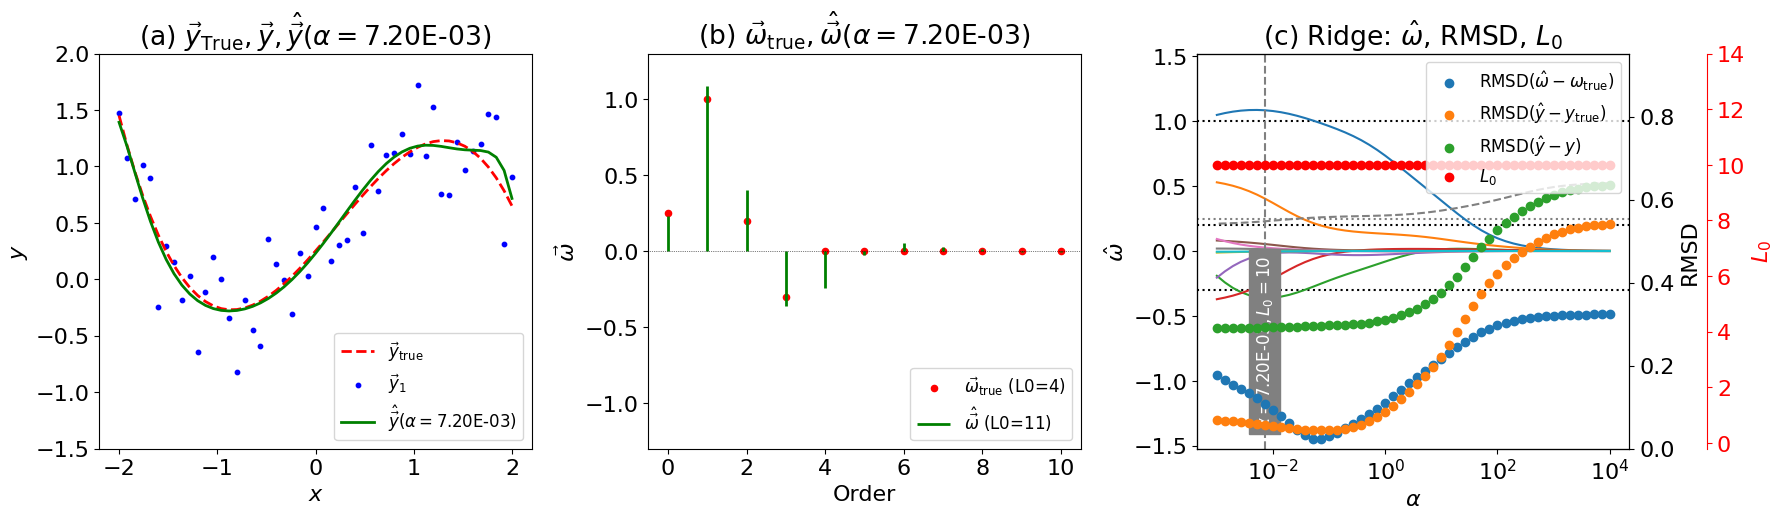

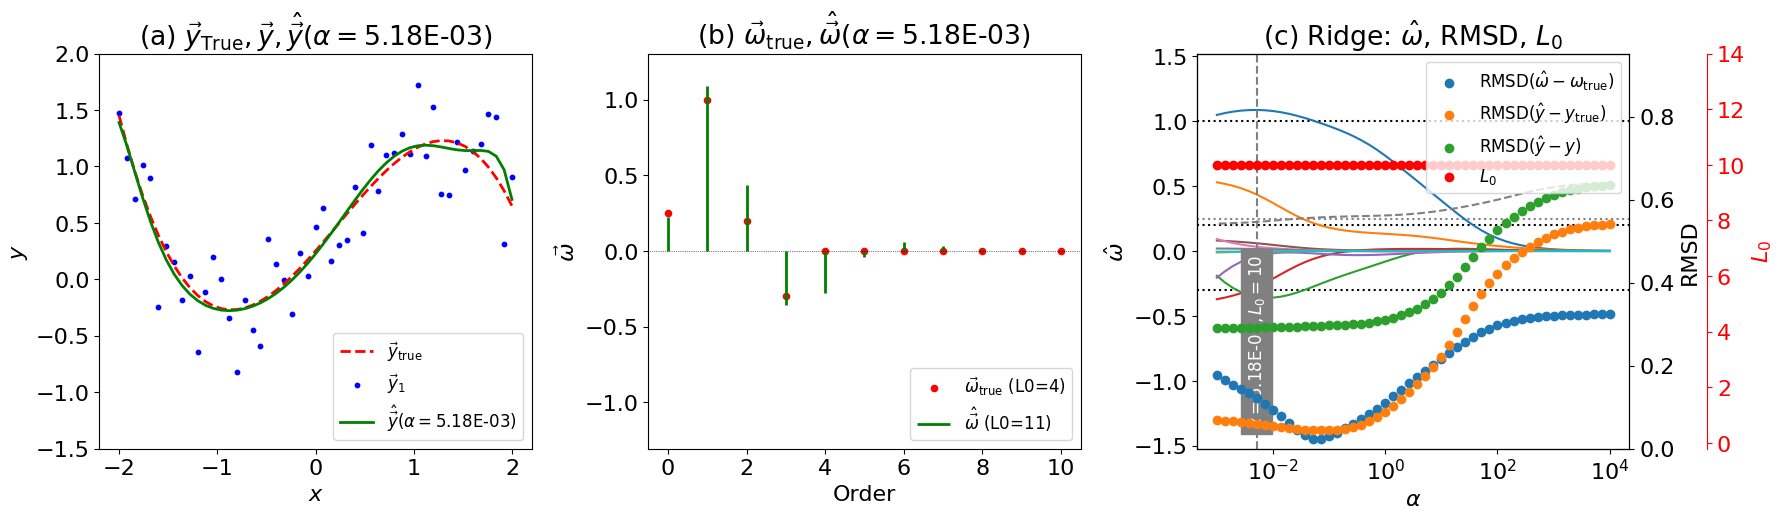

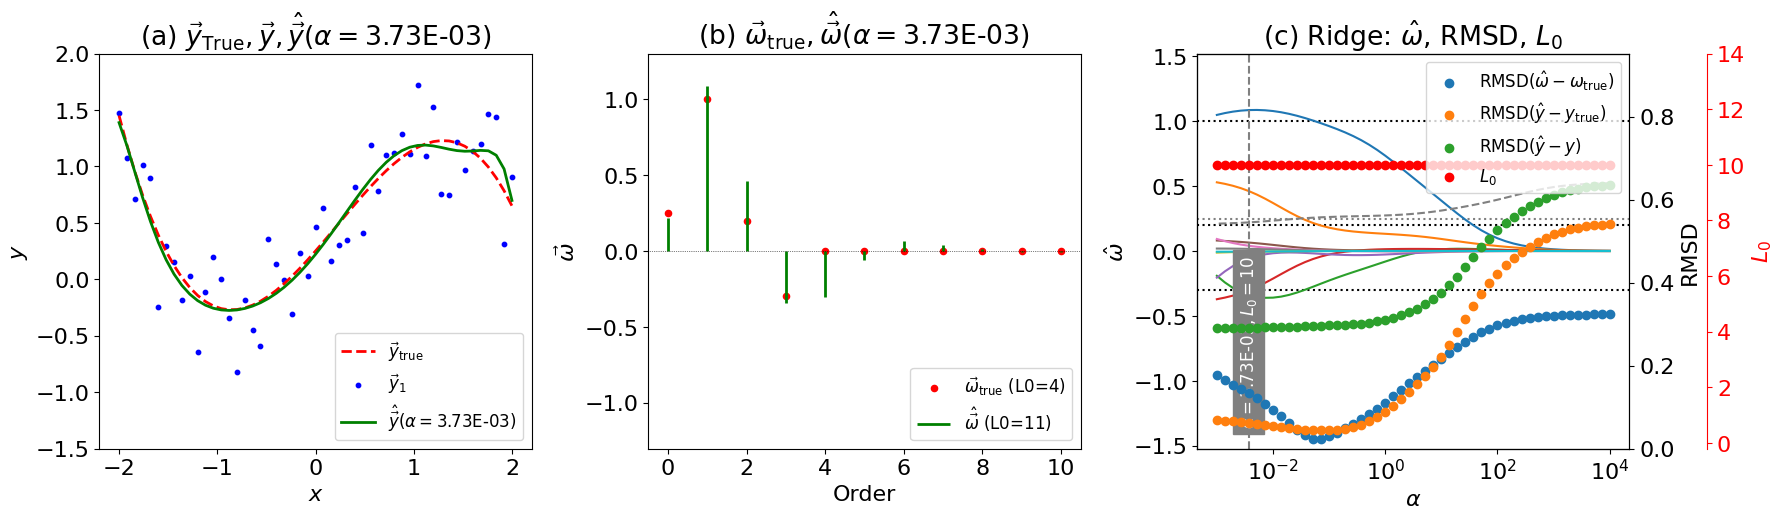

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Appendix/ARidge-Polynomial/ARidge-Polynomial-idx45-summary.pdf


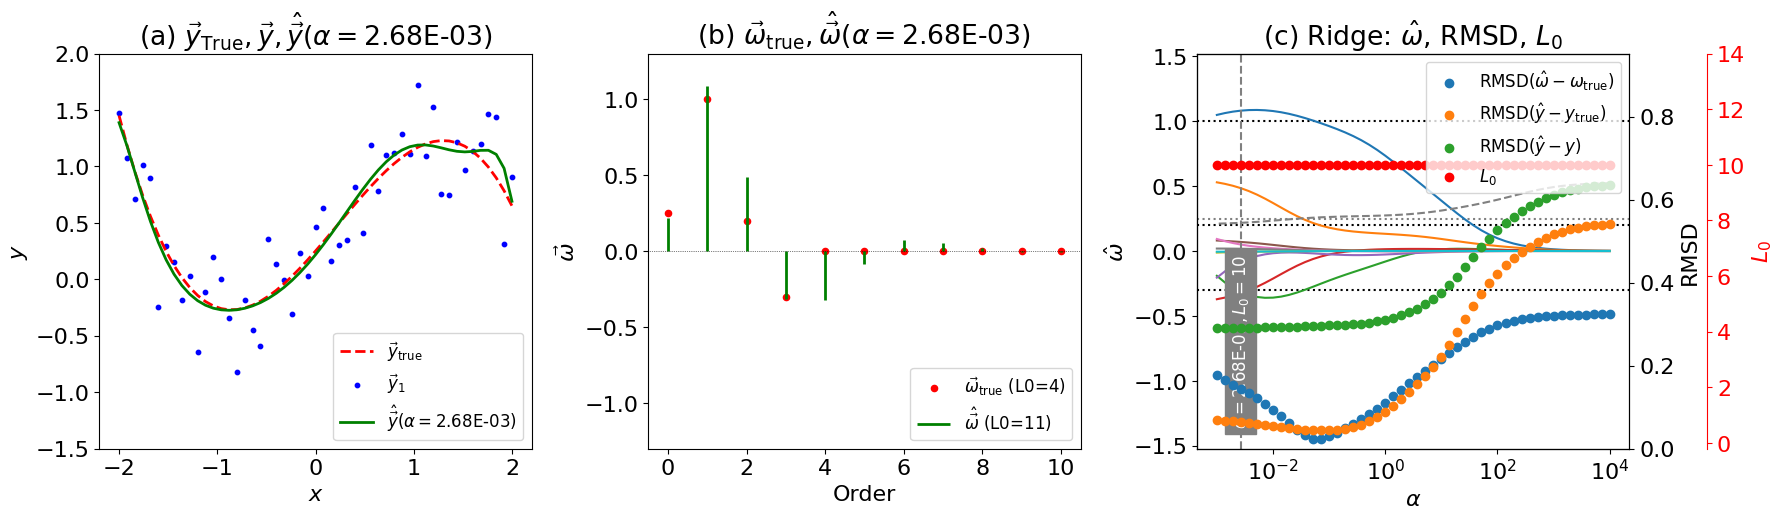

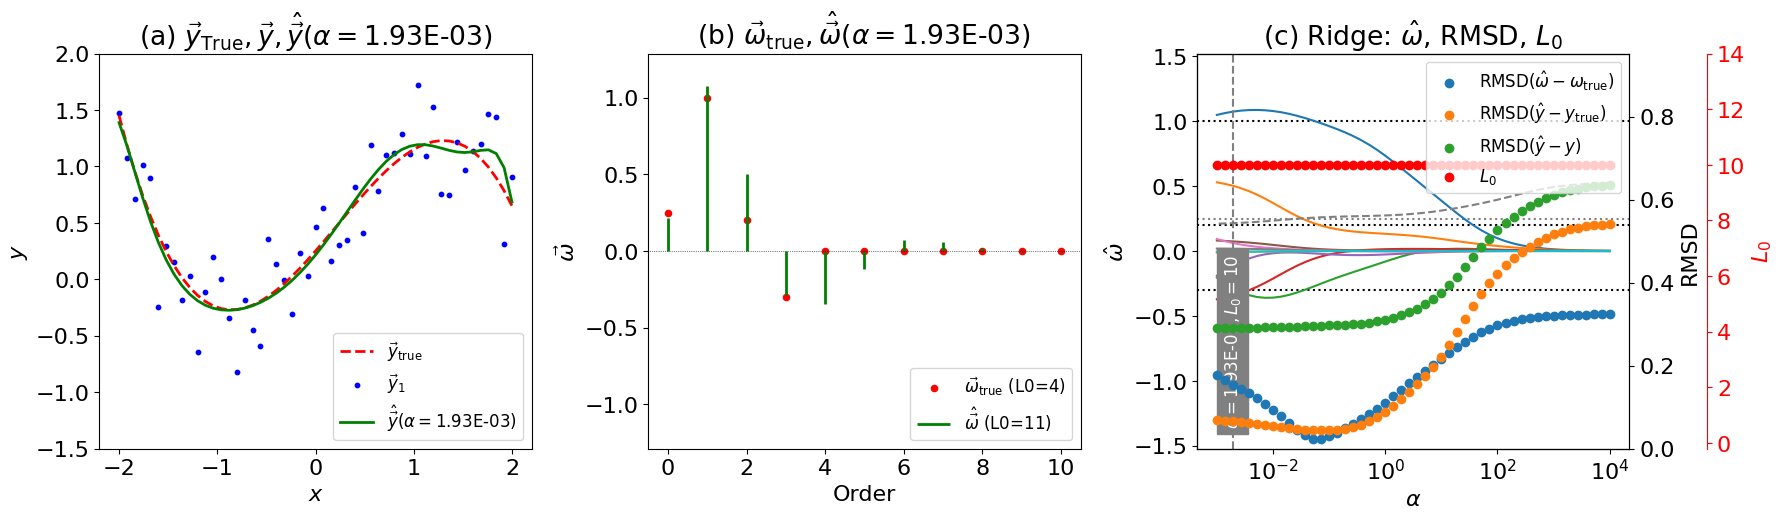

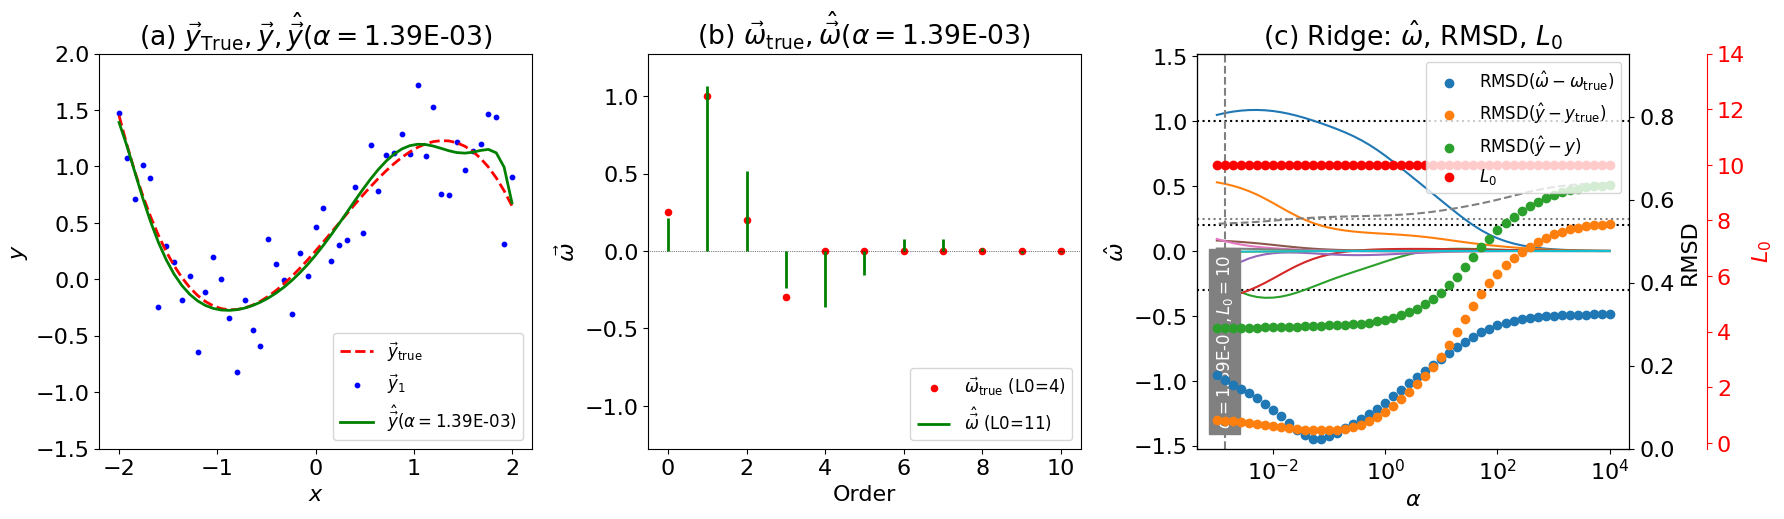

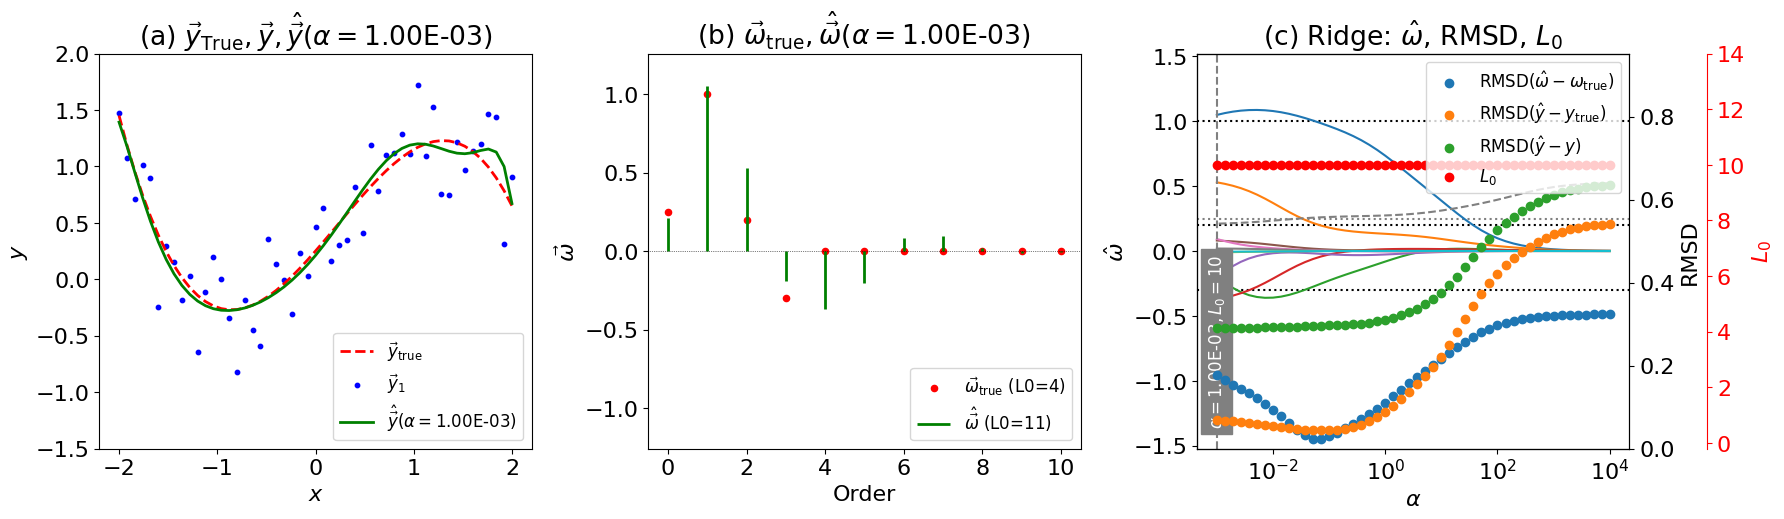

In [24]:
###########################################
for alpha_idx in range( n_alphas ):
  #########################################
  a_ = alphas[ alpha_idx ]
  #
  #########################################
  y_label_ = r'$\hat{\vec{y}}(\alpha=$%.2E$)$' % a_
  y_reg_set = [ hat_y_reg[alpha_idx], 0, y_label_, 'green', 2, 'solid' ]
  #
  y_sets     = [ y_true_set, y_1_set, y_reg_set ]
  #
  # fig = Grf_ydata( x, y_sets )
  #########################################
  w_idx_  = hat_omega[ alpha_idx ]
  a0_idx_ = hat_a0[ alpha_idx ]
  #
  w_all_idx_ = np.concatenate( [[a0_idx_], w_idx_] )
  w_all_idx_set = [ w_all_idx_, 0, r'$\hat{\vec{\omega}}$', 'green',  2, 'solid' ]
  w_sets = [ w_true_set, w_all_idx_set ]
  #
  #########################################
  # Graph
  #########################################
  plt.rcParams['font.size'] = 16
  #
  fig = plt.figure( figsize=(18,5) )
  fig.subplots_adjust(left=0.06, right=0.91, top=0.91, bottom=0.12, wspace=0.27)
  #
  ###########
  ax_y = fig.add_subplot(1, 3, 1)
  #
  title1 = r'(a) $\vec{y}_{\rm True}, \vec{y}, \hat{\vec{y}}(\alpha=$%.2E$)$' % a_
  SubGrf_ydata( ax_y, x, y_sets, title=title1 )
  #
  ###########
  ax_omega = fig.add_subplot(1, 3, 2)
  #
  title2 = r'(b) $\vec{\omega}_{\rm true}, \hat{\vec{\omega}}(\alpha=$%.2E$)$' % a_
  L0_ = SubGrf_omega( ax_omega, w_x_all, w_sets, title=title2 )
  #
  ###########
  ax_summary = fig.add_subplot(1, 3, 3)
  #
  title3 = r'(c) Ridge: $\hat{\omega}$, RMSD, $L_{0}$'
  SubGrf_omega_RMSD_L0( ax_summary, alphas, hat_omega, hat_a0, hat_L0, RMSD_sets, idx_=alpha_idx, title=title3 )
  #
  ###########
  plt.show()
  #
  ###########
  # 5つおきにグラフをpdf出力
  if (alpha_idx % 5)== 0:
    fname_ = FilePath + FileBaseName + '-idx%02d-summary.pdf' % alpha_idx
    print( fname_ )
    fig.savefig( fname_ )
  #